# Домашнее задание 2
### Андреев Никита

In [2]:
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.optimize as opt
import scipy.sparse
import sklearn.datasets
from sklearn.model_selection import train_test_split

#### Определим функцию $\sigma$:

## $\sigma_w(x)=\frac{e^{w^tx}}{1+e^{w^tx}}=\frac{1}{1+e^{-w^tx}}$

Тогда
$1-\sigma_w(x)=1-\frac{1}{1+e^{-w^tx}}=\frac{1}{1+e^{w^tx}}=\sigma_w(-x)$

## Функция, которую необходимо минимизировать:
## $f(w)=-\frac{1}{N}\sum\limits_1^n\log(\sigma_w(y_i x_i))$, $y_i =\pm 1$

#### Посчитаем производные:

### $\nabla\sigma_w(x)=\frac{e^{-w^tx}}{(1+e^{-w^tx})^2}x = \sigma_w(x) \sigma_w(-x)x$

### $\nabla f(w) = -\frac{1}{N}\sum\limits_1^n\sigma_w(-y_i x_i)y_i x_i$

### $\nabla^2 f(w) = \frac{1}{N}\sum\limits_1^n\sigma_w(y_i x_i)\sigma_w(-y_i x_i)x_i x_i^t=
\frac{1}{N}\sum\limits_1^n\sigma_w(x_i)\sigma_w(-x_i)x_i x_i^t$

Функции оракулов:

In [34]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def oracle(w, X, labels, outers=None, order=0, no_function=False):
    Xw = X.dot(w)
    sigmoids = [sigmoid(l * xw) for xw, l in zip(Xw, labels)]

    f = 0
    if not no_function:
        f = -1 / X.shape[0] * np.sum([np.log(s) for s in sigmoids])

    if order == 0:
        return f

    grad_coeffs = np.array([l * (1 - s) for s, l in zip(sigmoids, labels)])
    X1 = X.multiply(grad_coeffs.reshape(-1, 1))
    g = -1 / X.shape[0] * np.array(X1.sum(axis=0)).reshape(X.shape[1])

    if order == 1:
        return f, g, 0

    hess_coeffs = np.array([s * (1 - s) for s in sigmoids])
    # outers - массив x x^t flatten, который можно посчитать заранее
    if outers is None:
        h = 1 / X.shape[0] * np.sum([np.outer(x, x) * hess_coeffs[i] for i, x in enumerate(X.todense())], axis=0)
    else:
        outers1 = outers.multiply(hess_coeffs.reshape(-1, 1))
        h = 1 / X.shape[0] * np.array(outers1.sum(axis=0)).reshape((X.shape[1], X.shape[1]))

    if order == 2:
        return f, g, h

    
def function(w, X, labels):
    return oracle(w, X, labels)


def gradient(w, X, labels):
    return oracle(w, X, labels, order=1, no_function=True)[1]


def hessian(w, X, labels):
    return oracle(w, X, labels, order=2, no_function=True)[2]

#### Тесты для проверки правильности вычисления производных:

In [203]:
#численное дифференцирование
def der(fun, point, epsilon=np.sqrt(sys.float_info.epsilon)):
    return (fun(point + epsilon) - fun(point)) / epsilon

#считает среднюю относительную погрешность по всем кординатным осям в рандомной точке из [-R, R]^dim
def check_gradient(fun, grad, R, dim, args=(), diff_eps=np.sqrt(sys.float_info.epsilon)):
    w = np.random.random(dim)
    w = (2 * w - 1) * R
    dw = np.eye(dim)
    g = grad(w, *args)
    norm = np.dot(g, g)
    difs = [np.abs((np.dot(g, dw_i) - der(lambda t: fun(w + t * dw_i, *args), 0, diff_eps))) for dw_i in dw]
    return np.average(difs) / norm

#считает среднюю относительную погрешность по всем парам кординатных осей в рандомной точке из [-R, R]^dim
def check_hessian(grad, hess, R, dim, args=(), diff_eps=np.sqrt(sys.float_info.epsilon)):
    w = np.random.random(dim)
    w = (2 * w - 1) * R
    dw = np.eye(dim)
    h = hess(w, *args)
    norm = np.dot(h.flatten(), h.flatten())
    difs = [np.abs(np.dot(dw1, np.dot(h, dw2)) - der(lambda t: np.dot(grad(w + t * dw1, *args), dw2), 0, diff_eps)) for dw1 in dw
            for dw2 in dw]
    return np.average(difs) / norm


## В качестве данных впредь будем использовать три датасета:

a1a:

In [22]:
a1a = sklearn.datasets.load_svmlight_file('../data/a1a.txt')
X = a1a[0]
dummy = scipy.sparse.csr_matrix([[1] for i in range(X.shape[0])])
X_a1a = scipy.sparse.hstack([X, dummy])
labels_a1a = a1a[1]

breast cancer: (координаты нормированы от -1 до 1)

In [23]:
breast_cancer = sklearn.datasets.load_svmlight_file('../data/breast-cancer_scale.txt')
X = breast_cancer[0]
dummy = scipy.sparse.csr_matrix([[1] for i in range(X.shape[0])])
X_cancer = scipy.sparse.hstack([X, dummy])
labels_cancer = breast_cancer[1]-3

Случайный сгенерированный:

In [24]:
def random_dataset(alpha, beta):
    xs = np.random.normal(size=(1000, alpha.shape[0]))
    labels = np.array([np.sign(np.dot(alpha, x) + beta) for x in xs])
    return xs, labels


In [25]:
alpha = 2 * np.random.random(10) - 1
beta = 2 * np.random.random() - 1
X, labels_rand = random_dataset(alpha, beta)
dummy = scipy.sparse.csr_matrix([[1] for i in range(X.shape[0])])
X_rand = scipy.sparse.hstack([X, dummy])

Посмотрим, правильно ли посчитаны градиент и гессиан:

In [8]:
print('погрешность градиента =', check_gradient(function, gradient, 1, X_a1a.shape[1], args=[X_a1a, labels_a1a]))
print('погрешность гессиана =', check_hessian(gradient, hessian, 1, X_a1a.shape[1], args=[X_a1a, labels_a1a]))
#долго - большая размерность

погрешность градиента = 9.197712783263106e-09
погрешность гессиана = 3.1585345709744107e-10


In [206]:
print('погрешность градиента =', check_gradient(function, gradient, 1, X_cancer.shape[1], args=[X_cancer, labels_cancer]))
print('погрешность гессиана =', check_hessian(gradient, hessian, 1, X_cancer.shape[1], args=[X_cancer, labels_cancer]))

погрешность градиента = 4.844235722724385e-09
погрешность гессиана = 9.103220175676514e-09


In [10]:
print('погрешность градиента =', check_gradient(function, gradient, 1, X_rand.shape[1], args=[X_rand, labels_rand]))
print('погрешность гессиана =', check_hessian(gradient, hessian, 1, X_rand.shape[1], args=[X_rand, labels_rand]))

погрешность градиента = 2.1883069479385463e-08
погрешность гессиана = 3.150906688142897e-08


Результаты говорят о том, что всё правильно

#### Метод золотого сечения:

In [8]:
#на заданном интервале: возвращает точку минимума и число вызовов функции
def golden_search_bounded(fun, a0, b0, eps=100*sys.float_info.epsilon, args=()):
    ratio = (1 + 5 ** 0.5) / 2

    def step(a, b, c, fc, onumber):
        if b - a < eps:
            return a, fun(a, *args), onumber + 1
        else:
            d = a + b - c
            fd = fun(d)
            if c > d:
                c, d = d, c
                fc, fd = fd, fc
            if fc < fd:
                return step(a, d, c, fc, onumber + 1)
            else:
                return step(c, b, d, fd, onumber + 1)

    c0 = a0 + (b0 - a0) / ratio
    solution = step(a0, b0, c0, fun(c0, *args), 0)
    return solution[0], solution[2]



#общий случай используя bracket
def golden_search(fun, eps=100*sys.float_info.epsilon, args=()):
    a, _, b, _, _, _, onumber = opt.bracket(fun, args=args)
    if b < a:
        a, b = b, a
    # print(b-a, eps)
    gsb = golden_search_bounded(fun, a, b, eps=eps, args=args)
    return gsb[0], gsb[1] + onumber


Метод для построения графиков:

In [4]:
def graph(x, y, x_l=None, y_l=None, title=None):
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set(xlabel=x_l, ylabel=y_l, title=title)
    ax.grid()
    plt.show()
    

Сгенерируем полиномы 2, 3 и 5 степени и построим графики чтобы понять с каких интервалов начинать поиск минимума:

-0.95717287 + -0.75630972x + 0.72343828x ^ 2


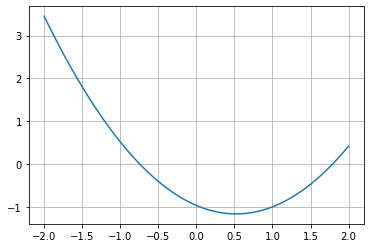

0.97490814 + 0.80688161x + 0.05165432x ^ 2 + -0.52669906x ^ 3


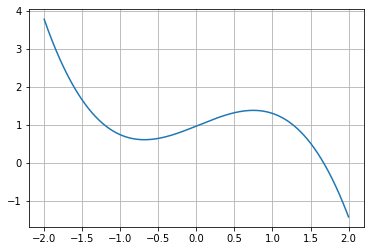

0.74540317 + -0.50950527x + 0.96825081x ^ 2 + -0.0243777x ^ 3 +-0.33768442x ^ 4 + 0.13532899x ^ 5


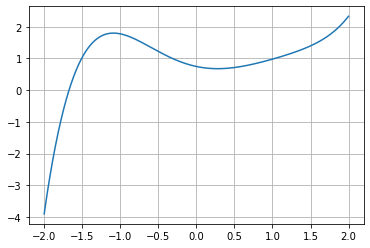

In [6]:
c2, c3, c5 = [-0.95717287, -0.75630972, 0.72343828], [0.97490814, 0.80688161, 0.05165432, -0.52669906], [0.74540317,
                                                                                                         -0.50950527,
                                                                                                         0.96825081,
                                                                                                         -0.0243777,
                                                                                                         -0.33768442,
                                                                                                         0.13532899]

def pol2(x):
    return c2[0] + c2[1] * x + c2[2] * x ** 2


def pol3(x):
    return c3[0] + c3[1] * x + c3[2] * x ** 2 + c3[3] * x ** 3


def pol5(x):
    return c5[0] + c5[1] * x + c5[2] * x ** 2 + c5[3] * x ** 3 + c5[4] * x ** 4 + c5[5] * x ** 5

xs = np.arange(-2, 2, 0.001)
print(str(c2[0]) + ' + ' + str(c2[1]) + 'x + ' + str(c2[2]) + 'x ^ 2')
graph(xs, [pol2(x) for x in xs])

print(str(c3[0]) + ' + ' + str(c3[1]) + 'x + ' + str(c3[2]) + 'x ^ 2 + ' + str(c3[3]) + 'x ^ 3')
graph(xs, [pol3(x) for x in xs])

print(str(c5[0]) + ' + ' + str(c5[1]) + 'x + ' + str(c5[2]) + 'x ^ 2 + ' + str(c5[3]) + 'x ^ 3 +' + str(
          c5[4]) + 'x ^ 4 + ' + str(c5[5]) + 'x ^ 5')
graph(xs, [pol5(x) for x in xs])

Сравним метод с методом Брэнта:

In [9]:
x, fev = golden_search_bounded(pol2, -0.5, 1.5)

opt1 = opt.minimize_scalar(pol2, bracket=[-0.5, 0, 1.5], method='brent')
x1, fev1 = opt1['x'], opt1['nfev']

print('x golden =', x, ', nfev =', fev)
print('x brent =', x1, ', nfev =', fev1)
print('pol2(x golden) - pol2(x brent) =', pol2(x) - pol2(x1))

x golden = 0.522718912712355 , nfev = 99
x brent = 0.5227188895728239 , nfev = 9
pol2(x golden) - pol2(x brent) = 2.220446049250313e-16


In [10]:
x, fev = golden_search_bounded(pol3, -1.5, 0)

opt1 = opt.minimize_scalar(pol3, bracket=[-1.5, -1, 0], method='brent')
x1, fev1 = opt1['x'], opt1['nfev']

print('x golden =', x, ', nfev =', fev)
print('x brent =', x1, ', nfev =', fev1)
print('pol3(x golden) - pol3(x brent) =', pol3(x) - pol3(x1))

x golden = -0.6826567432036533 , nfev = 122
x brent = -0.6826567604746772 , nfev = 14
pol3(x golden) - pol3(x brent) = 0.0


In [11]:
x, fev = golden_search_bounded(pol5, -0.5, 1.0)

opt1 = opt.minimize_scalar(pol5, bracket=[-0.5, 0, 1], method='brent')
x1, fev1 = opt1['x'], opt1['nfev']

print('x golden =', x, ', nfev =', fev)
print('x brent =', x1, ', nfev =', fev1)
print('pol5(x golden) - pol5(x brent) =', pol5(x) - pol5(x1))

x golden = 0.2790908941572795 , nfev = 127
x brent = 0.2790908876932606 , nfev = 16
pol5(x golden) - pol5(x brent) = 0.0


Метод Брэнта лучше

#### Поиск шага с использованием условия Армихо:

In [329]:
def armiho(fun, c=0.1, k=20, f0=None, df0=None):
    x = 1
    oracle = 0

    if f0 == None:
        f0 = fun(0)
        oracle += 1

    if df0 is None:
        df0 = der(fun, 0)
        oracle += 2

    fx = fun(x)
    fkx = fun(k * x)
    oracle += 2

    while True:
        if fx > f0 + c * df0 * x:
            x /= k
            fkx = fx
            fx = fun(x)
            oracle += 1
        elif fkx < f0 + k * c * df0 * x:
            x *= k
            fx = fkx
            fkx = fun(x)
            oracle += 1
        else:
            break

    return x, oracle


#### Поиск шага с помощью оценки константы Липшица (нашёл название схема Нестерова):

In [15]:
def nester(fun, f0, d, L0=1):
    L = L0
    oracle = 0

    while fun(1 / L) > f0 - 1 / (2 * L) * np.dot(d, d):
        L *= 2
        oracle += 1
    oracle += 1

    return L, oracle


Чтобы решить систему $Hx = y$, где $H$ - положительно определённая матрица, будем использовать разложение Холецкого:

In [229]:
def solve(G, d):
    if np.linalg.matrix_rank(G) < G.shape[0]:
        G = G + 0.0001 * np.eye(G.shape[0])
    L = np.linalg.cholesky(G)
    Ltx = scipy.linalg.solve_triangular(L, d, lower=True)
    return scipy.linalg.solve_triangular(np.transpose(L), Ltx, lower=False)


## Градиентный спуск и метод Ньютона:

Разница только в выборе направления - поэтому всё в одном методе

Параметры:

1. oracle - оракул
2. start - начальная точка
3. method - 'gradient descent' или 'newton'
4. one_dim_search - способ выбора шага:
    'unit step',
    'brent',
    'golden',
    'armiho',
    'nester',
    'wolf'
5. args - аргументы для оракула (X, labels, outers(опционально))
6. search_kwargs - аргументы для метода одномерной оптимизации
7. условие(я) остановки: epsilon, max_iter, max_time, max_oracle


Возвращает:

1. x - результат
2. iterations - range от 0 до количества итераций
3. times - массив времён от начала вычисления до текущего шага
4. values - массив значений функции
5. grad_ratios - массив отношений $||\nabla f(w_k)||^2/||\nabla f(w_0)||^2$
6. fcalls - масиив количества вызовов функции на каждой итерации
7. gcalls - аналогично для градиента
8. hcalls - аналогично для гессиана

В реализации в main.py возвращаются только последние элементы перечисленных массивов

In [116]:
def optimization_task(oracle, start, method='gradient descent', one_dim_search=None, args=(),
                      search_kwargs=dict([]), epsilon=0, max_iter=float('inf'), max_time=float('inf')):
    iterations, fcalls, gcalls, hcalls, times, values, grad_ratios = [], [], [], [], [], [], []
    start_time, k, fc, gc, hc = time.time(), 0, 0, 0, 0
    x = start

    if method == 'gradient descent':
        ord = 1
        if one_dim_search is None:
            one_dim_search = 'brent'
    elif method == 'newton':
        ord = 2
        if one_dim_search is None:
            one_dim_search = 'unit step'

    f0, g0, _ = oracle(x, *args, order=1)
    fc += 1
    gc += 1

    if one_dim_search == 'nester':
        L, L0 = 2, 0
        if 'L0' in search_kwargs.keys():
            L0 = 2 * search_kwargs['L0']
            L = L0

    while True:
        fk, gk, hk = oracle(x, *args, order=ord)
        # в реализации в main.py стоит флаг no_function
        fc += 1
        gc += 1
        if ord == 2:
            hc += 1
            
        if method == 'gradient descent':
            d = -gk
        elif method == 'newton':
            d = -solve(hk, gk)
            
        ratio = np.dot(gk, gk) / np.dot(g0, g0)
        iterations.append(k)
        k += 1
        fcalls.append(fc)
        gcalls.append(gc)
        hcalls.append(hc)
        times.append(time.time() - start_time)
        values.append(fk)
        grad_ratios.append(ratio)

        if ratio <= epsilon or k > max_iter or times[-1] > max_time:
            break

        fun = lambda alpha: oracle(x + d * alpha, *args)

        if one_dim_search == 'unit step':
            alpha = 1
        elif one_dim_search == 'golden':
            alpha, oracle_counter = golden_search(fun, **search_kwargs)
            fc += oracle_counter
        elif one_dim_search == 'brent':
            solution = opt.minimize_scalar(fun)
            alpha = solution['x']
            fc += solution['nfev']
        elif one_dim_search == 'armiho':
            alpha, oracle_counter = armiho(fun, **search_kwargs, f0=fk, df0=np.dot(gk, d))
            fc += oracle_counter
        elif one_dim_search == 'wolf':
            f_for_wolf = lambda z: oracle(z, *args)
            g_for_wolf = lambda z: oracle(z, *args, order=1, no_function=True)[1]
            solution = opt.line_search(f_for_wolf, g_for_wolf, x, d, **search_kwargs, gfk=gk, old_fval=fk)
            alpha = solution[0]
            if alpha == None:
                alpha = 1
            fc += solution[1]
            gc += solution[2]
        elif one_dim_search == 'nester':
            L, oracle_counter = nester(fun, fk, gk, L0=max(L / 2, L0))
            alpha = 1 / L
            fc += oracle_counter

        x = x + d * alpha

    return x, iterations, times, values, grad_ratios, fcalls, gcalls, hcalls


# Градиентный спуск:

#### Метод для построения нескольких графиков логарифмов функций

In [267]:
def graph_several(xs, ys, labels, end=None, beg=0, x_l=None, y_l=None, title=None):
    fig, ax = plt.subplots(figsize=(15,7))
    if end is None:
        end = max([max(x) for x in xs])
    ends = [np.argmin([np.abs(p - end) for p in x]) for x in xs]
    begs = [np.argmin([np.abs(p - beg) for p in x]) for x in xs]
    xs1 = [xs[i][begs[i]:ends[i]+1] for i in range(len(xs))]
    ys1 = [ys[i][begs[i]:ends[i]+1] for i in range(len(xs))]

    def logs(y):
        return [np.log(v) for v in y]

    for i in range(len(xs)):
        ax.plot(xs1[i], logs(ys1[i]), label=labels[i])

    ax.set(xlabel=x_l, ylabel=y_l, title=title)
    ax.grid()
    ax.legend(fontsize=20)
    plt.show()


#### Минимальные значения функций с помощью встроенных методов:

In [35]:
w0_a1a = (2 * np.random.random(X_a1a.shape[1]) - 1) / 2
#начальная точка

w_true_a1a = opt.minimize(function, w0_a1a, args=(X_a1a, labels_a1a), jac = gradient)['x']

f_min_a1a = function(w_true_a1a, X_a1a, labels_a1a)
print('a1a function minimum =', f_min_a1a)

a1a function minimum = 0.29787614080425834


In [36]:
w0_cancer = (2 * np.random.random(X_cancer.shape[1]) - 1) / 2
#начальная точка

w_true_cancer = opt.minimize(function, w0_cancer, args=(X_cancer, labels_cancer), jac = gradient)['x']

f_min_cancer = function(w_true_cancer, X_cancer, labels_cancer)
print('cancer function minimum =', f_min_cancer)

cancer function minimum = 0.07531873773624799


In [37]:
w0_rand = (2 * np.random.random(X_rand.shape[1]) - 1) / 2
#начальная точка

w_true_rand = opt.minimize(function, w0_rand, args=(X_rand, labels_rand), jac = gradient)['x']

f_min_rand = function(w_true_rand, X_rand, labels_rand)
print('rand function minimum =', f_min_rand)

rand function minimum = 1.233384914727727e-05


### Armiho: зависимость  от $c$:

In [330]:
a1, i1, t1, v1, r1, fc1, gc1, hc1 = optimization_task(oracle, w0_a1a, method='gradient descent', args=[X_a1a, labels_a1a],
                                          one_dim_search='armiho', max_time=10, search_kwargs=dict([('c', 0.9)]))
a2, i2, t2, v2, r2, fc2, gc2, hc2 = optimization_task(oracle, w0_a1a, method='gradient descent', args=[X_a1a, labels_a1a],
                                          one_dim_search='armiho', max_time=10, search_kwargs=dict([('c', 0.7)]))
a3, i3, t3, v3, r3, fc3, gc3, hc3 = optimization_task(oracle, w0_a1a, method='gradient descent', args=[X_a1a, labels_a1a],
                                          one_dim_search='armiho', max_time=10, search_kwargs=dict([('c', 0.5)]))
a4, i4, t4, v4, r4, fc4, gc4, hc4 = optimization_task(oracle, w0_a1a, method='gradient descent', args=[X_a1a, labels_a1a],
                                          one_dim_search='armiho', max_time=10, search_kwargs=dict([('c', 0.3)]))
a5, i5, t5, v5, r5, fc5, gc5, hc5 = optimization_task(oracle, w0_a1a, method='gradient descent', args=[X_a1a, labels_a1a],
                                           one_dim_search='armiho', max_time=10, search_kwargs=dict([('c', 0.1)]))

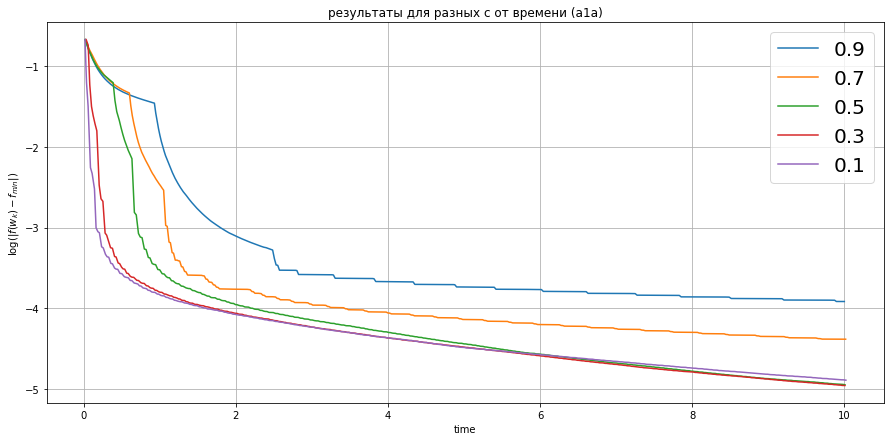

In [331]:
vs = np.array([v1-f_min_a1a, v2-f_min_a1a, v3-f_min_a1a, v4-f_min_a1a, v5-f_min_a1a])
graph_several([t1, t2, t3, t4, t5], vs,
              labels=['0.9', '0.7', '0.5', '0.3', '0.1'],
              x_l='time', y_l='$\log(|f(w_k)-f_{min}|)$', title='результаты для разных c от времени (a1a)')

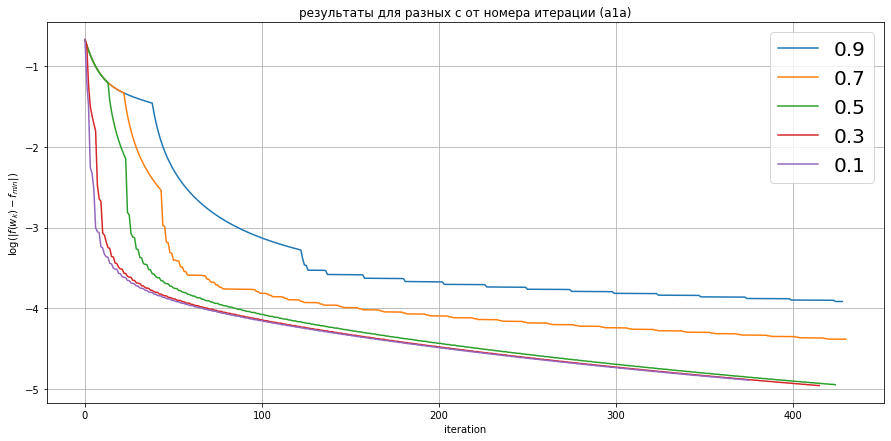

In [332]:
vs = np.array([v1-f_min_a1a, v2-f_min_a1a, v3-f_min_a1a, v4-f_min_a1a, v5-f_min_a1a])
graph_several([i1, i2, i3, i4, i5], vs,
              labels=['0.9', '0.7', '0.5', '0.3', '0.1'],
              x_l='iteration', y_l='$\log(|f(w_k)-f_{min}|)$', title='результаты для разных c от номера итерации (a1a)')

In [333]:
a1, i1, t1, v1, r1, fc1, gc1, hc1 = optimization_task(oracle, w0_cancer, method='gradient descent', args=[X_cancer, labels_cancer],
                                          one_dim_search='armiho', max_time=10, search_kwargs=dict([('c', 0.9)]))
a2, i2, t2, v2, r2, fc2, gc2, hc2 = optimization_task(oracle, w0_cancer, method='gradient descent', args=[X_cancer, labels_cancer],
                                          one_dim_search='armiho', max_time=10, search_kwargs=dict([('c', 0.7)]))
a3, i3, t3, v3, r3, fc3, gc3, hc3 = optimization_task(oracle, w0_cancer, method='gradient descent', args=[X_cancer, labels_cancer],
                                          one_dim_search='armiho', max_time=10, search_kwargs=dict([('c', 0.5)]))
a4, i4, t4, v4, r4, fc4, gc4, hc4 = optimization_task(oracle, w0_cancer, method='gradient descent', args=[X_cancer, labels_cancer],
                                          one_dim_search='armiho', max_time=10, search_kwargs=dict([('c', 0.3)]))
a5, i5, t5, v5, r5, fc5, gc5, hc5 = optimization_task(oracle, w0_cancer, method='gradient descent', args=[X_cancer, labels_cancer],
                                           one_dim_search='armiho', max_time=10, search_kwargs=dict([('c', 0.1)]))

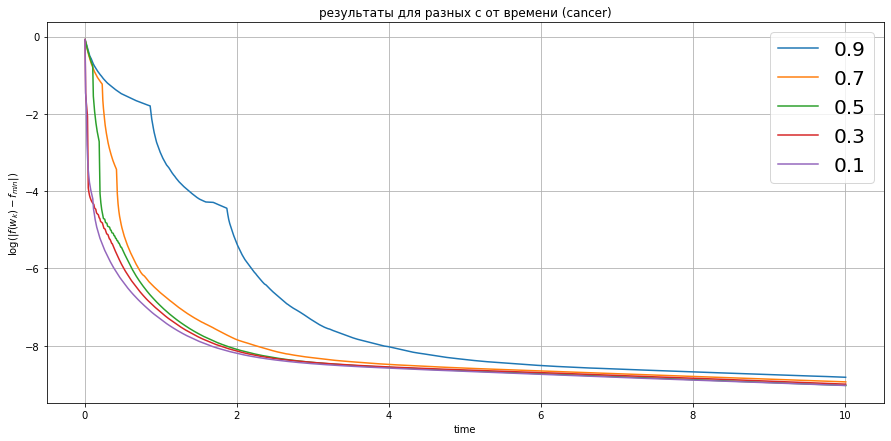

In [334]:
vs = np.array([v1-f_min_cancer, v2-f_min_cancer, v3-f_min_cancer, v4-f_min_cancer, v5-f_min_cancer])
graph_several([t1, t2, t3, t4, t5], vs,
              labels=['0.9', '0.7', '0.5', '0.3', '0.1'],
              x_l='time', y_l='$\log(|f(w_k)-f_{min}|)$', title='результаты для разных c от времени (cancer)')

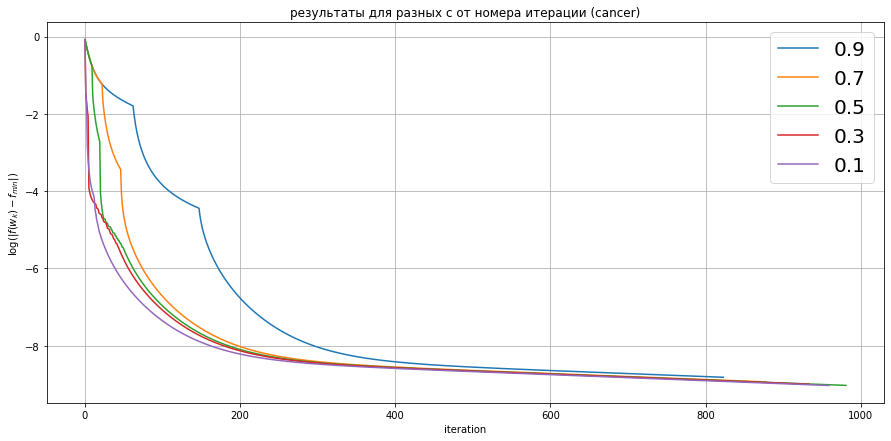

In [335]:
vs = np.array([v1-f_min_cancer, v2-f_min_cancer, v3-f_min_cancer, v4-f_min_cancer, v5-f_min_cancer])
graph_several([i1, i2, i3, i4, i5], vs,
              labels=['0.9', '0.7', '0.5', '0.3', '0.1'],
              x_l='iteration', y_l='$\log(|f(w_k)-f_{min}|)$', title='результаты для разных c от номера итерации (cancer)')

Для $c$, близких к 1, за одну итерацию функция не может сильно уменьшиться. Впредь будем использовать $c$ = 0.1 - при меньших значениях ситауция не особо меняется.

### Armiho: зависимость  от $k$ (a1a):

In [323]:
a1, i1, t1, v1, r1, fc1, gc1, hc1 = optimization_task(oracle, w0_a1a, method='gradient descent', args=[X_a1a, labels_a1a],
                                          one_dim_search='armiho', max_time=10, search_kwargs=dict([('k', 50)]))
a2, i2, t2, v2, r2, fc2, gc2, hc2 = optimization_task(oracle, w0_a1a, method='gradient descent', args=[X_a1a, labels_a1a],
                                          one_dim_search='armiho', max_time=10, search_kwargs=dict([('k', 30)]))
a3, i3, t3, v3, r3, fc3, gc3, hc3 = optimization_task(oracle, w0_a1a, method='gradient descent', args=[X_a1a, labels_a1a],
                                          one_dim_search='armiho', max_time=10, search_kwargs=dict([('k', 20)]))
a4, i4, t4, v4, r4, fc4, gc4, hc4 = optimization_task(oracle, w0_a1a, method='gradient descent', args=[X_a1a, labels_a1a],
                                          one_dim_search='armiho', max_time=10, search_kwargs=dict([('k', 10)]))
a5, i5, t5, v5, r5, fc5, gc5, hc5 = optimization_task(oracle, w0_a1a, method='gradient descent', args=[X_a1a, labels_a1a],
                                           one_dim_search='armiho', max_time=10, search_kwargs=dict([('k', 5)]))

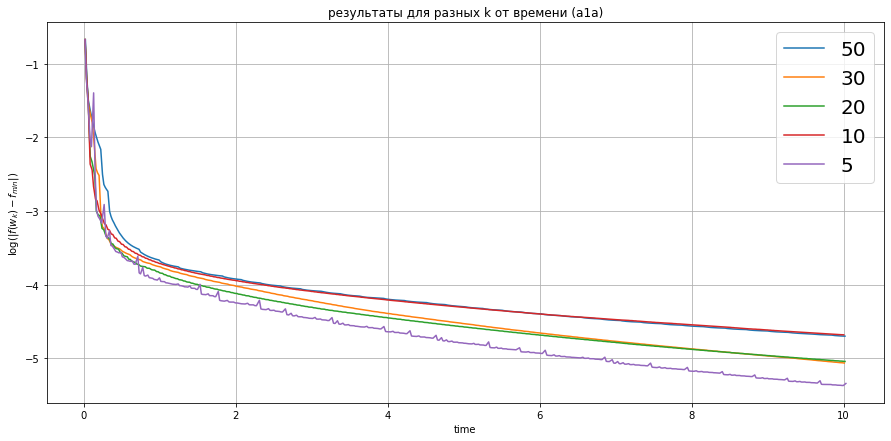

In [324]:
vs = np.array([v1-f_min_a1a, v2-f_min_a1a, v3-f_min_a1a, v4-f_min_a1a, v5-f_min_a1a])
graph_several([t1, t2, t3, t4, t5], vs,
              labels=['50', '30', '20', '10', '5'],
              x_l='time', y_l='$\log(|f(w_k)-f_{min}|)$', title='результаты для разных k от времени (a1a)')

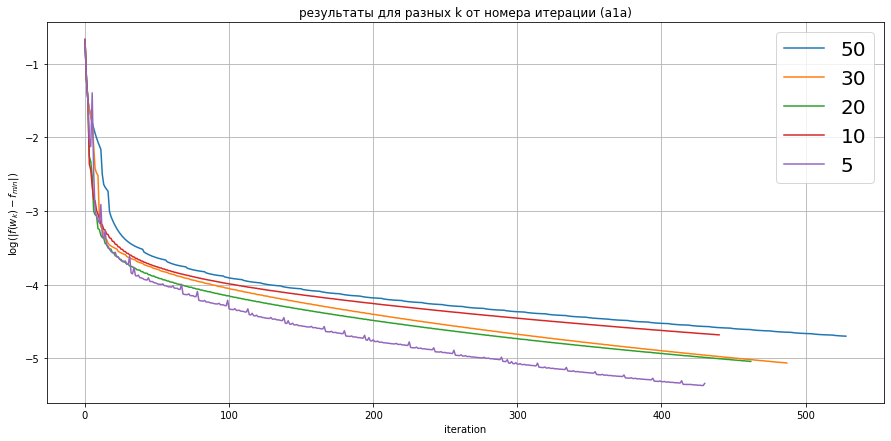

In [325]:
vs = np.array([v1-f_min_a1a, v2-f_min_a1a, v3-f_min_a1a, v4-f_min_a1a, v5-f_min_a1a])
graph_several([i1, i2, i3, i4, i5], vs,
              labels=['50', '30', '20', '10', '5'],
              x_l='iteration', y_l='$\log(|f(w_k)-f_{min}|)$', title='результаты для разных k от номера итерации (a1a)')

In [326]:
a1, i1, t1, v1, r1, fc1, gc1, hc1 = optimization_task(oracle, w0_cancer, method='gradient descent', args=[X_cancer, labels_cancer],
                                          one_dim_search='armiho', max_time=10, search_kwargs=dict([('k', 50)]))
a2, i2, t2, v2, r2, fc2, gc2, hc2 = optimization_task(oracle, w0_cancer, method='gradient descent', args=[X_cancer, labels_cancer],
                                          one_dim_search='armiho', max_time=10, search_kwargs=dict([('k', 30)]))
a3, i3, t3, v3, r3, fc3, gc3, hc3 = optimization_task(oracle, w0_cancer, method='gradient descent', args=[X_cancer, labels_cancer],
                                          one_dim_search='armiho', max_time=10, search_kwargs=dict([('k', 20)]))
a4, i4, t4, v4, r4, fc4, gc4, hc4 = optimization_task(oracle, w0_cancer, method='gradient descent', args=[X_cancer, labels_cancer],
                                          one_dim_search='armiho', max_time=10, search_kwargs=dict([('k', 10)]))
a5, i5, t5, v5, r5, fc5, gc5, hc5 = optimization_task(oracle, w0_cancer, method='gradient descent', args=[X_cancer, labels_cancer],
                                           one_dim_search='armiho', max_time=10, search_kwargs=dict([('k', 5)]))

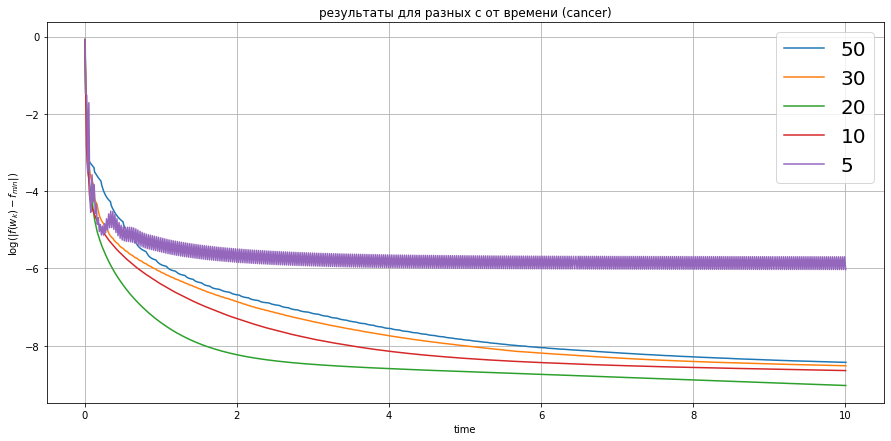

In [327]:
vs = np.array([v1-f_min_cancer, v2-f_min_cancer, v3-f_min_cancer, v4-f_min_cancer, v5-f_min_cancer])
graph_several([t1, t2, t3, t4, t5], vs,
              labels=['50', '30', '20', '10', '5'],
              x_l='time', y_l='$\log(|f(w_k)-f_{min}|)$', title='результаты для разных c от времени (cancer)')

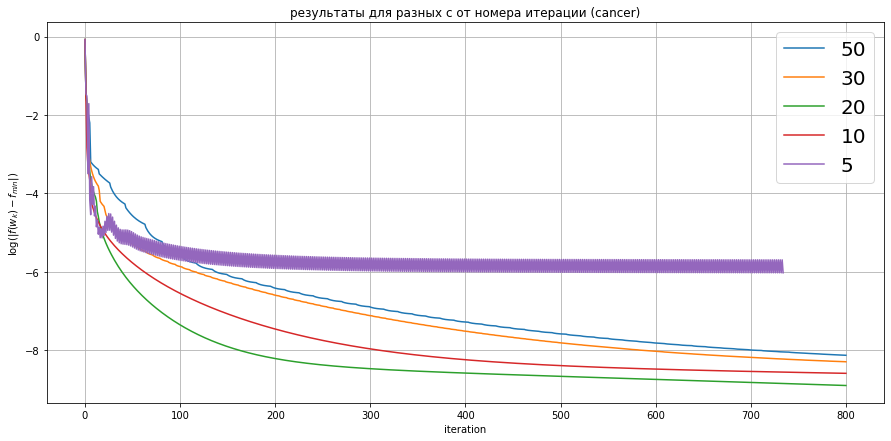

In [328]:
vs = np.array([v1-f_min_cancer, v2-f_min_cancer, v3-f_min_cancer, v4-f_min_cancer, v5-f_min_cancer])
graph_several([i1, i2, i3, i4, i5], vs,
              labels=['50', '30', '20', '10', '5'], end=800,
              x_l='iteration', y_l='$\log(|f(w_k)-f_{min}|)$', title='результаты для разных c от номера итерации (cancer)')

При $k<10$ происходит что-то странное и функция иногда увеличивается после итерации. Будем использовать $k=20$.

### Wolf: зависимость от $с_2$:

Зависимость от $c_1$ (коэфицента для условия Армихо) похожа на аналогичную в методе Армихо, так что здесь не представлена

In [336]:
a1, i1, t1, v1, r1, fc1, gc1, hc1 = optimization_task(oracle, w0_cancer, method='gradient descent', args=[X_cancer, labels_cancer],
                                          one_dim_search='wolf', max_time=10, search_kwargs=dict([('c2', 0.9)]))
a2, i2, t2, v2, r2, fc2, gc2, hc2 = optimization_task(oracle, w0_cancer, method='gradient descent', args=[X_cancer, labels_cancer],
                                          one_dim_search='wolf', max_time=10, search_kwargs=dict([('c2', 0.5)]))
a3, i3, t3, v3, r3, fc3, gc3, hc3 = optimization_task(oracle, w0_cancer, method='gradient descent', args=[X_cancer, labels_cancer],
                                          one_dim_search='wolf', max_time=10, search_kwargs=dict([('c2', 0.3)]))
a4, i4, t4, v4, r4, fc4, gc4, hc4 = optimization_task(oracle, w0_cancer, method='gradient descent', args=[X_cancer, labels_cancer],
                                          one_dim_search='wolf', max_time=10, search_kwargs=dict([('c2', 0.1)]))
a5, i5, t5, v5, r5, fc5, gc5, hc5 = optimization_task(oracle, w0_cancer, method='gradient descent', args=[X_cancer, labels_cancer],
                                           one_dim_search='wolf', max_time=10, search_kwargs=dict([('c2', 0.001)]))

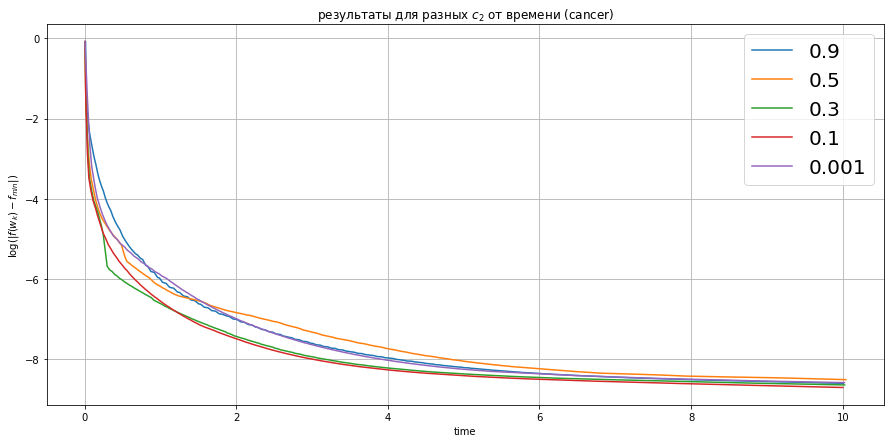

In [337]:
vs = np.array([v1-f_min_cancer, v2-f_min_cancer, v3-f_min_cancer, v4-f_min_cancer, v5-f_min_cancer])
graph_several([t1, t2, t3, t4, t5], vs,
              labels=['0.9', '0.5', '0.3', '0.1', '0.001'],
              x_l='time', y_l='$\log(|f(w_k)-f_{min}|)$', title='результаты для разных $c_2$ от времени (cancer)')

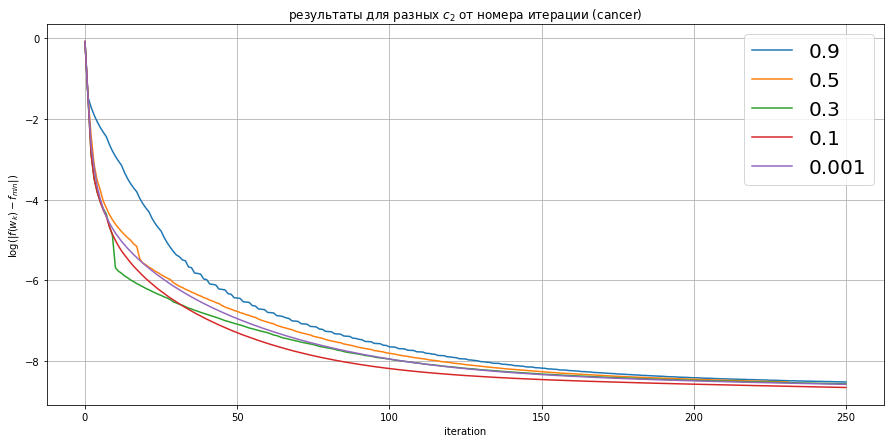

In [340]:
vs = np.array([v1-f_min_cancer, v2-f_min_cancer, v3-f_min_cancer, v4-f_min_cancer, v5-f_min_cancer])
graph_several([i1, i2, i3, i4, i5], vs,
              labels=['0.9', '0.5', '0.3', '0.1', '0.001'], end=250,
              x_l='iteration', y_l='$\log(|f(w_k)-f_{min}|)$', title='результаты для разных $c_2$ от номера итерации (cancer)')

In [341]:
a1, i1, t1, v1, r1, fc1, gc1, hc1 = optimization_task(oracle, w0_a1a, method='gradient descent', args=[X_a1a, labels_a1a],
                                          one_dim_search='wolf', max_time=10, search_kwargs=dict([('c2', 0.9)]))
a2, i2, t2, v2, r2, fc2, gc2, hc2 = optimization_task(oracle, w0_a1a, method='gradient descent', args=[X_a1a, labels_a1a],
                                          one_dim_search='wolf', max_time=10, search_kwargs=dict([('c2', 0.5)]))
a3, i3, t3, v3, r3, fc3, gc3, hc3 = optimization_task(oracle, w0_a1a, method='gradient descent', args=[X_a1a, labels_a1a],
                                          one_dim_search='wolf', max_time=10, search_kwargs=dict([('c2', 0.3)]))
a4, i4, t4, v4, r4, fc4, gc4, hc4 = optimization_task(oracle, w0_a1a, method='gradient descent', args=[X_a1a, labels_a1a],
                                          one_dim_search='wolf', max_time=10, search_kwargs=dict([('c2', 0.1)]))
a5, i5, t5, v5, r5, fc5, gc5, hc5 = optimization_task(oracle, w0_a1a, method='gradient descent', args=[X_a1a, labels_a1a],
                                           one_dim_search='wolf', max_time=10, search_kwargs=dict([('c2', 0.001)]))

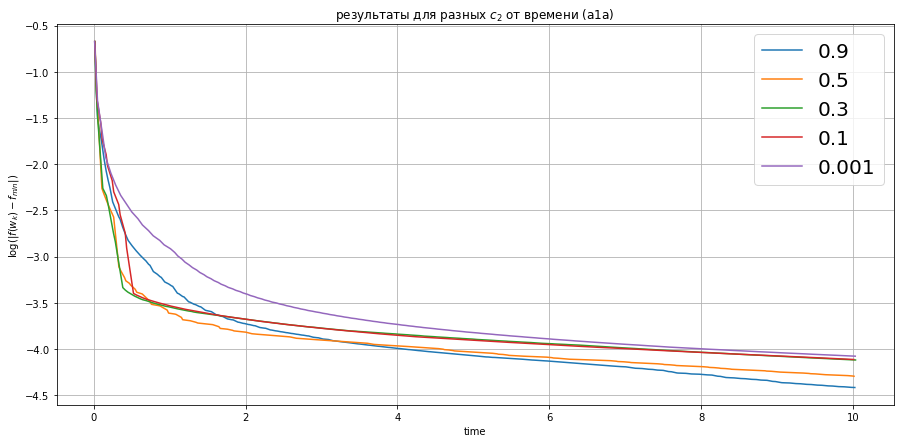

In [342]:
vs = np.array([v1-f_min_a1a, v2-f_min_a1a, v3-f_min_a1a, v4-f_min_a1a, v5-f_min_a1a])
graph_several([t1, t2, t3, t4, t5], vs,
              labels=['0.9', '0.5', '0.3', '0.1', '0.001'],
              x_l='time', y_l='$\log(|f(w_k)-f_{min}|)$', title='результаты для разных $c_2$ от времени (a1a)')

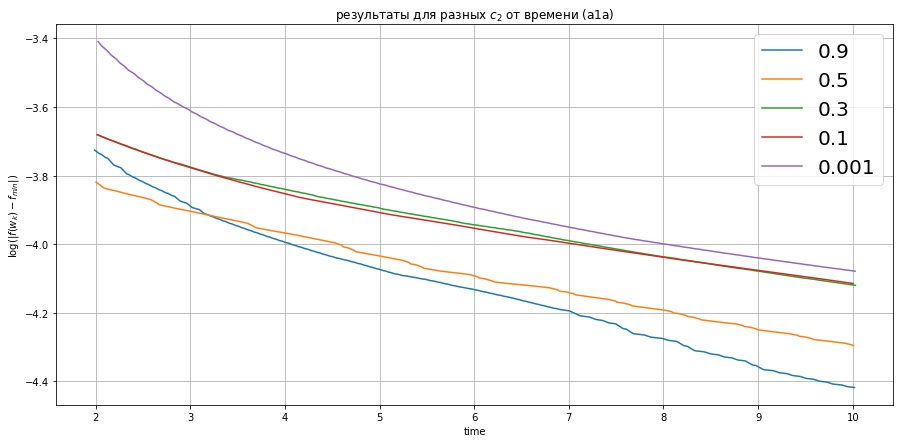

In [343]:
vs = np.array([v1-f_min_a1a, v2-f_min_a1a, v3-f_min_a1a, v4-f_min_a1a, v5-f_min_a1a])
graph_several([t1, t2, t3, t4, t5], vs,
              labels=['0.9', '0.5', '0.3', '0.1', '0.001'], beg=2,
              x_l='time', y_l='$\log(|f(w_k)-f_{min}|)$', title='результаты для разных $c_2$ от времени (a1a)')

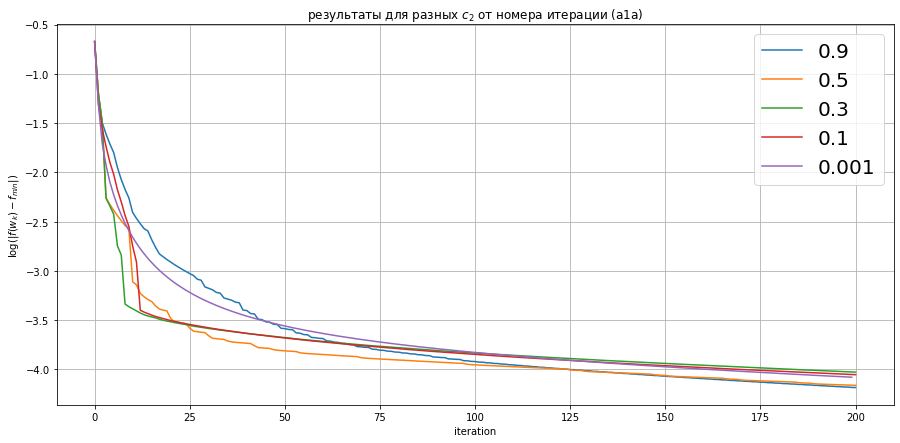

In [346]:
vs = np.array([v1-f_min_a1a, v2-f_min_a1a, v3-f_min_a1a, v4-f_min_a1a, v5-f_min_a1a])
graph_several([i1, i2, i3, i4, i5], vs,
              labels=['0.9', '0.5', '0.3', '0.1', '0.001'], end=200,
              x_l='iteration', y_l='$\log(|f(w_k)-f_{min}|)$', title='результаты для разных $c_2$ от номера итерации (a1a)')

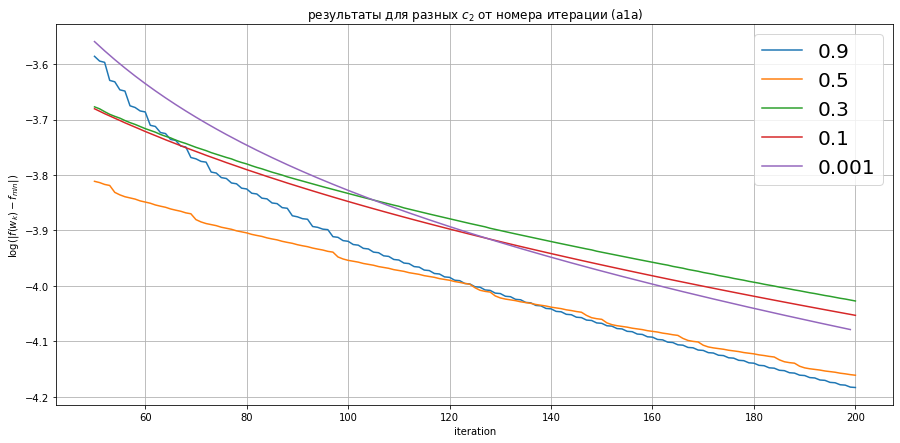

In [347]:
vs = np.array([v1-f_min_a1a, v2-f_min_a1a, v3-f_min_a1a, v4-f_min_a1a, v5-f_min_a1a])
graph_several([i1, i2, i3, i4, i5], vs,
              labels=['0.9', '0.5', '0.3', '0.1', '0.001'], beg=50, end=200,
              x_l='iteration', y_l='$\log(|f(w_k)-f_{min}|)$', title='результаты для разных $c_2$ от номера итерации (a1a)')

Не сильно большая разница, будем использовать $c_2=0.9$ - по умолчанию в linesearch

In [86]:
a1, i1, t1, v1, r1, fc1, gc1, hc1 = optimization_task(oracle, w0_rand, method='gradient descent', args=[X_rand, labels_rand],
                                          one_dim_search='wolf', max_time=10, search_kwargs=dict([('c2', 0.9)]))
a2, i2, t2, v2, r2, fc2, gc2, hc2 = optimization_task(oracle, w0_rand, method='gradient descent', args=[X_rand, labels_rand],
                                          one_dim_search='wolf', max_time=10, search_kwargs=dict([('c2', 0.2)]))
a3, i3, t3, v3, r3, fc3, gc3, hc3 = optimization_task(oracle, w0_rand, method='gradient descent', args=[X_rand, labels_rand],
                                          one_dim_search='wolf', max_time=10, search_kwargs=dict([('c2', 0.15)]))
a4, i4, t4, v4, r4, fc4, gc4, hc4 = optimization_task(oracle, w0_rand, method='gradient descent', args=[X_rand, labels_rand],
                                          one_dim_search='wolf', max_time=10, search_kwargs=dict([('c2', 0.1)]))
a5, i5, t5, v5, r5, fc5, gc5, hc5 = optimization_task(oracle, w0_rand, method='gradient descent', args=[X_rand, labels_rand],
                                           one_dim_search='wolf', max_time=10, search_kwargs=dict([('c2', 0.001)]))

C:\Users\Nikita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Nikita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Nikita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Nikita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Nikita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The 

Вероятно, что метод Вульфа не сходится из-за того, что минимума нет впринципе: поскольку датасет был получен разделением точек гиперплоскостью, оптимальным $w$ будет вектор нормали к этой гиперплоскости с наибольшей нормой $|w|$ (т.е. инфимум функции достигается при $|w|\rightarrow \infty$)

## Градиентный спуск: сравнение разных стратегий


#### Сancer:

In [91]:
a1, i1, t1, v1, r1, fc1, gc1, hc1 = optimization_task(oracle, w0_cancer, method='gradient descent', args=[X_cancer, labels_cancer],
                                          one_dim_search='brent', max_time=30)
a2, i2, t2, v2, r2, fc2, gc2, hc2 = optimization_task(oracle, w0_cancer, method='gradient descent', args=[X_cancer, labels_cancer],
                                          one_dim_search='golden', max_time=30, search_kwargs=dict([('eps', 0.00001)]))
a3, i3, t3, v3, r3, fc3, gc3, hc3 = optimization_task(oracle, w0_cancer, method='gradient descent', args=[X_cancer, labels_cancer],
                                          one_dim_search='armiho', max_time=30)
a4, i4, t4, v4, r4, fc4, gc4, hc4 = optimization_task(oracle, w0_cancer, method='gradient descent', args=[X_cancer, labels_cancer],
                                          one_dim_search='wolf', max_time=30)
a5, i5, t5, v5, r5, fc5, gc5, hc5 = optimization_task(oracle, w0_cancer, method='gradient descent', args=[X_cancer, labels_cancer],
                                           one_dim_search='nester', max_time=30)

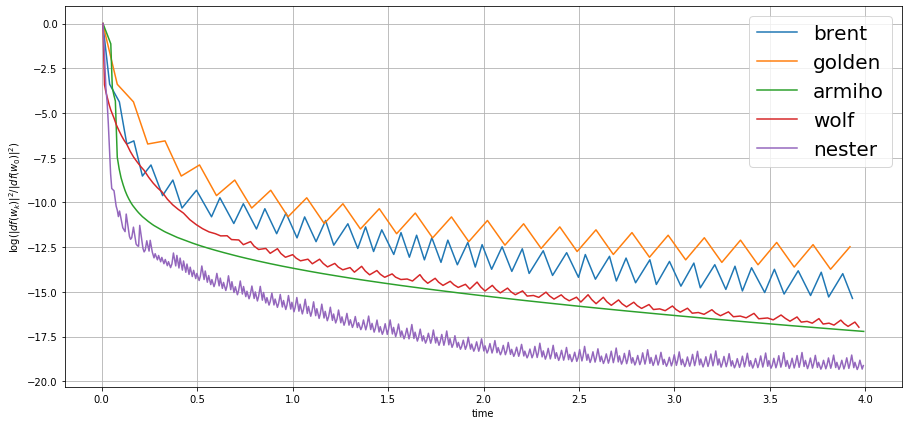

In [104]:
graph_several([t1, t2, t3, t4, t5], [r1, r2, r3, r4, r5],
              labels=['brent', 'golden', 'armiho', 'wolf', 'nester'], beg=0, end=4,
              x_l='time', y_l='$\log(|d f(w_k)|^2/|d f(w_0)|^2)$')

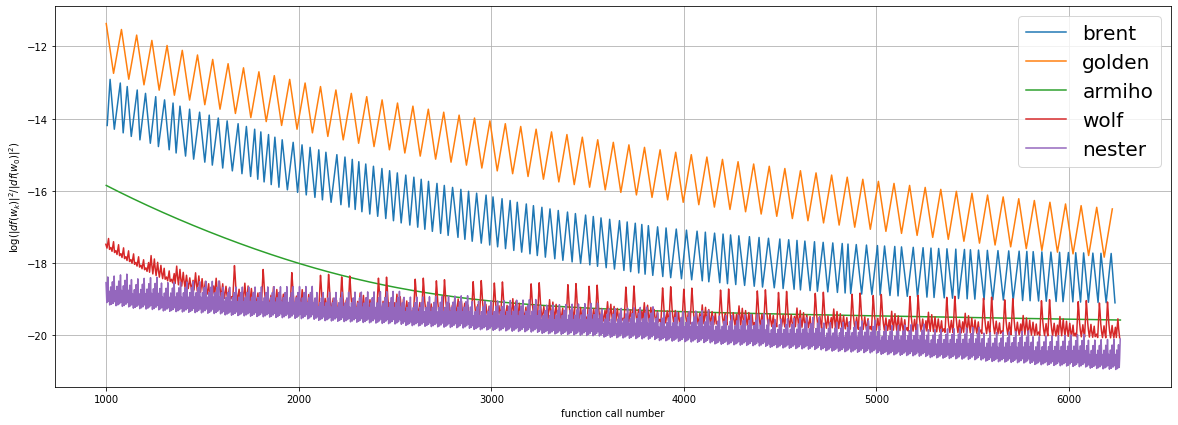

In [98]:
graph_several([fc1, fc2, fc3, fc4, fc5], [r1, r2, r3, r4, r5],
              labels=['brent', 'golden', 'armiho', 'wolf', 'nester'], beg=1000,
              x_l='function call number', y_l='$\log(| df(w_k)|^2/| df(w_0)|^2)$')

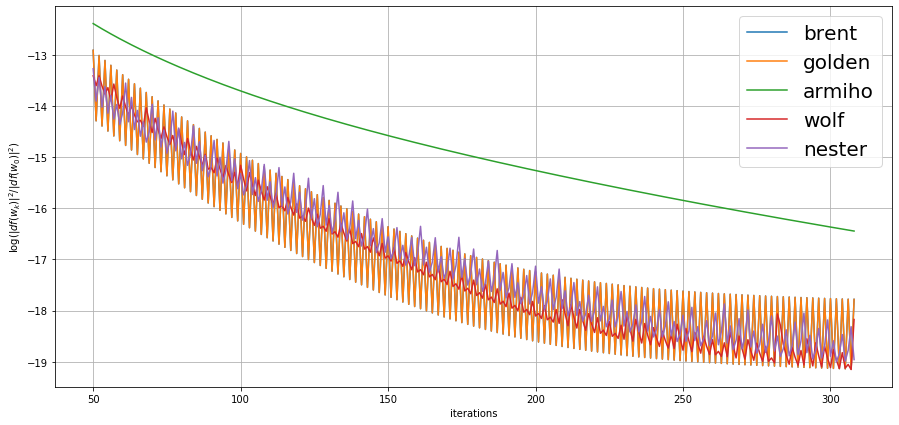

In [106]:
graph_several([i1, i2, i3, i4, i5], [r1, r2, r3, r4, r5],
              labels=['brent', 'golden', 'armiho', 'wolf', 'nester'], beg=50,
              x_l='iterations', y_l='$\log(| df(w_k)|^2/| df(w_0)|^2)$')

#### $\log(|f(w_k)-f_{min}|)$ для a1a:

In [187]:
a1, i1, o1, t1, v1, r1 = optimization_task(oracle, w0_a1a, method='gradient descent', args=[X_a1a, labels_a1a],
                                          one_dim_search='brent', max_iter=150)
a2, i2, o2, t2, v2, r2 = optimization_task(oracle, w0_a1a, method='gradient descent', args=[X_a1a, labels_a1a],
                                          one_dim_search='golden', max_iter=150, search_kwargs=dict([('eps', 0.1)]))
a3, i3, o3, t3, v3, r3 = optimization_task(oracle, w0_a1a, method='gradient descent', args=[X_a1a, labels_a1a],
                                          one_dim_search='armiho', max_iter=150, search_kwargs=dict([('x0', 50)]))
a4, i4, o4, t4, v4, r4 = optimization_task(oracle, w0_a1a, method='gradient descent', args=[X_a1a, labels_a1a],
                                          one_dim_search='wolf', max_iter=150, search_kwargs=dict([('c2', 0.1)]))
a5, i5, o5, t5, v5, r5 = optimization_task(oracle, w0_a1a, method='gradient descent', args=[X_a1a, labels_a1a],
                                           one_dim_search='nester', max_iter=150)

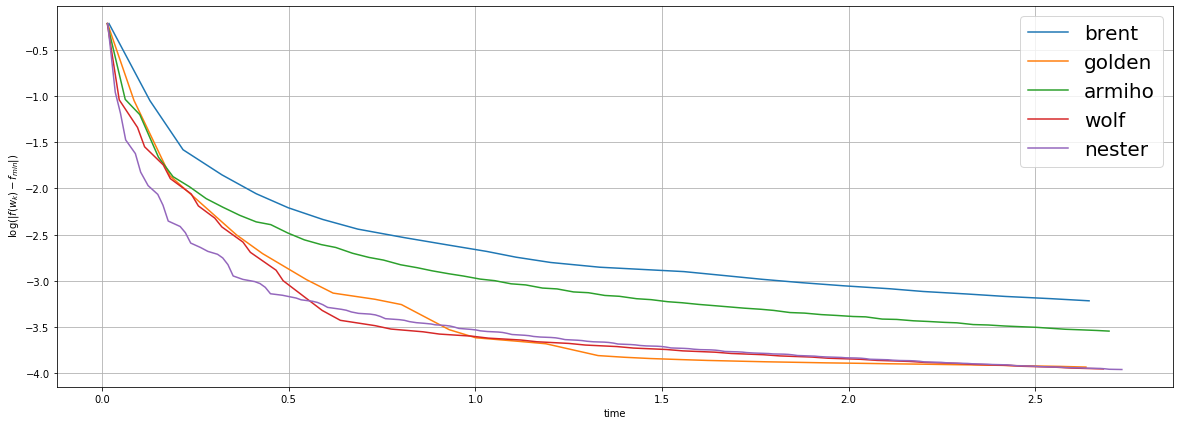

In [188]:
vs = np.array([v1, v2, v3, v4, v5]) - f_min_a1a
graph_several([t1, t2, t3, t4, t5], vs,
              labels=['brent', 'golden', 'armiho', 'wolf', 'nester'],
              x_l='time', y_l=' $\log(|f(w_k)-f_{min}|)$')

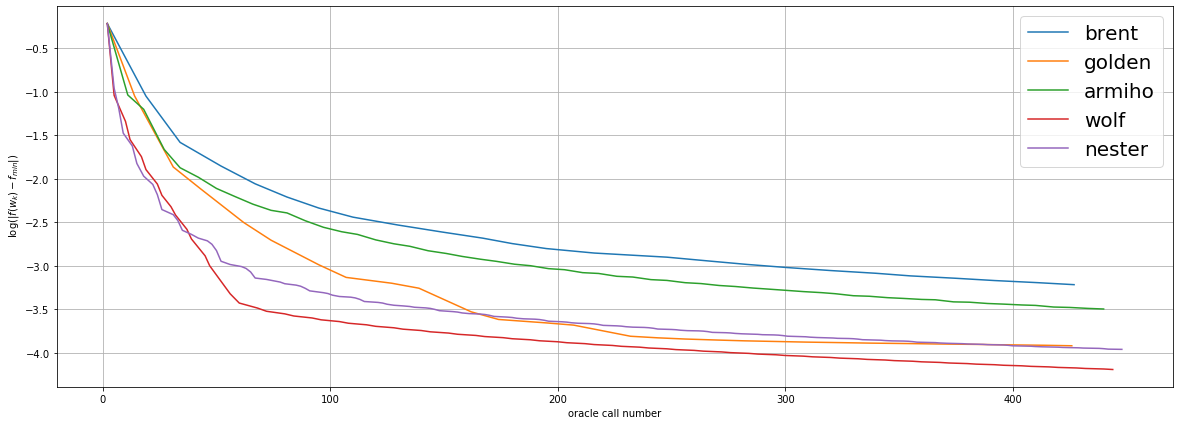

In [189]:
vs = np.array([v1, v2, v3, v4, v5]) - f_min_a1a
graph_several([o1, o2, o3, o4, o5], vs,
              labels=['brent', 'golden', 'armiho', 'wolf', 'nester'],
              x_l='oracle call number', y_l=' $\log(|f(w_k)-f_{min}|)$')

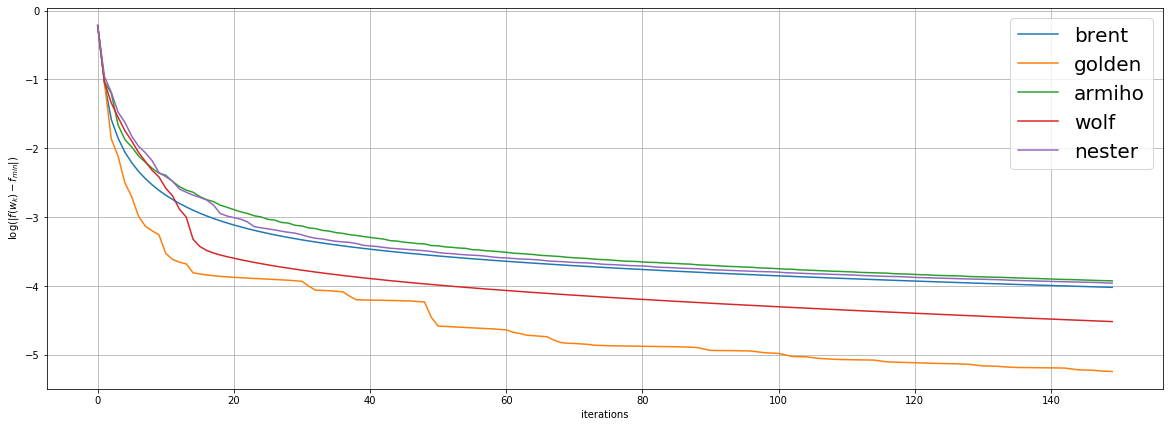

In [190]:
vs = np.array([v1, v2, v3, v4, v5]) - f_min_a1a
graph_several([i1, i2, i3, i4, i5], vs,
              labels=['brent', 'golden', 'armiho', 'wolf', 'nester'],
              x_l='iterations', y_l=' $\log(|f(w_k)-f_{min}|)$')

#### $\log(\frac{|\nabla f(w_k)|^2}{|\nabla f(w_0)|^2})$ для сгенерированного датасета:

In [198]:
a1, i1, o1, t1, v1, r1 = optimization_task(oracle, w0_rand, method='gradient descent', args=[X_rand, labels_rand],
                                           one_dim_search='brent', max_time=5)
a2, i2, o2, t2, v2, r2 = optimization_task(oracle, w0_rand, method='gradient descent', args=[X_rand, labels_rand],
                                           one_dim_search='golden', max_time=5, search_kwargs=dict([('eps', 0.1)]))
a3, i3, o3, t3, v3, r3 = optimization_task(oracle, w0_rand, method='gradient descent', args=[X_rand, labels_rand],
                                           one_dim_search='armiho', max_time=5, search_kwargs=dict([('x0', 50)]))
a4, i4, o4, t4, v4, r4 = optimization_task(oracle, w0_rand, method='gradient descent', args=[X_rand, labels_rand],
                                           one_dim_search='wolf', max_time=5, search_kwargs=dict([('c2', 0.1)]))
a5, i5, o5, t5, v5, r5 = optimization_task(oracle, w0_rand, method='gradient descent', args=[X_rand, labels_rand],
                                           one_dim_search='nester', max_time=5)

C:\Users\Nikita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Nikita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


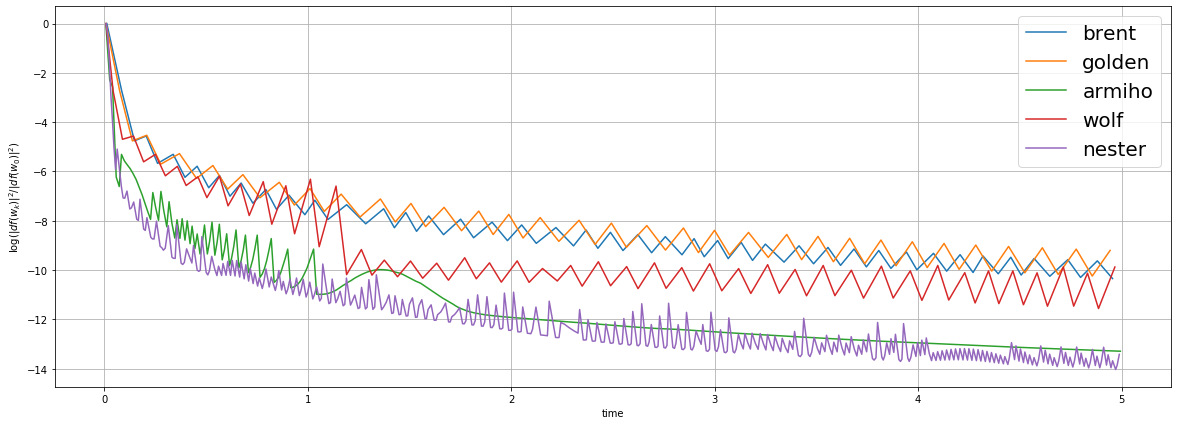

In [199]:
graph_several([t1, t2, t3, t4, t5], [r1, r2, r3, r4, r5],
              labels=['brent', 'golden', 'armiho', 'wolf', 'nester'],
              x_l='time', y_l='$\log(|d f(w_k)|^2/|d f(w_0)|^2)$')

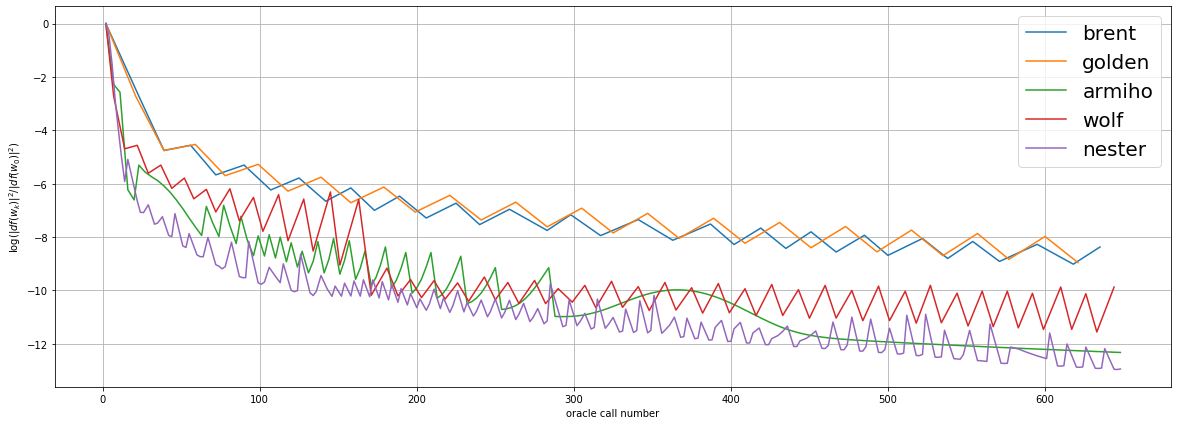

In [200]:
graph_several([o1, o2, o3, o4, o5], [r1, r2, r3, r4, r5],
              labels=['brent', 'golden', 'armiho', 'wolf', 'nester'],
              x_l='oracle call number', y_l='$\log(| df(w_k)|^2/| df(w_0)|^2)$')

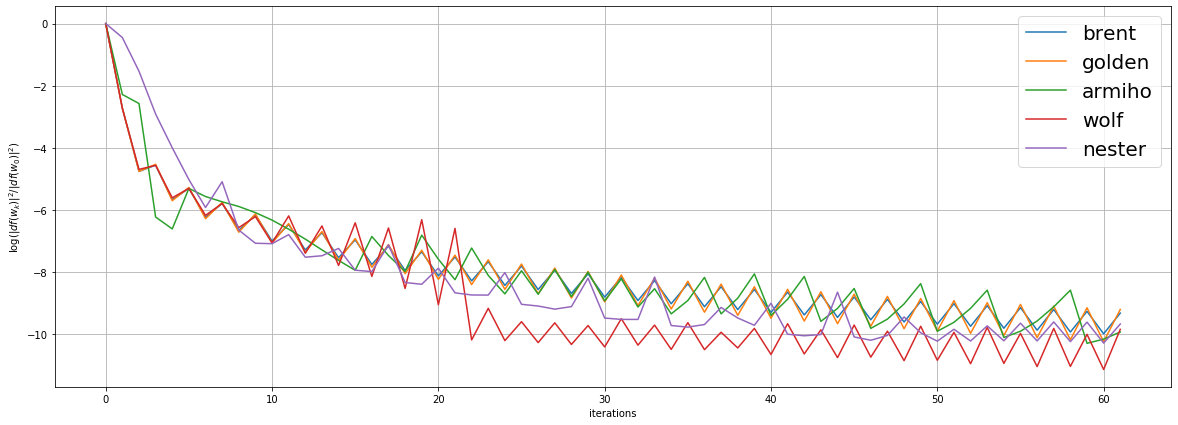

In [201]:
graph_several([i1, i2, i3, i4, i5], [r1, r2, r3, r4, r5],
              labels=['brent', 'golden', 'armiho', 'wolf', 'nester'],
              x_l='iterations', y_l='$\log(|d f(w_k)|^2/|d f(w_0)|^2)$')

# Метод Ньютона:

Заранее поссчитанные outers для датасетов:

In [108]:
outers_a1a = scipy.sparse.csr_matrix([np.outer(x, x).flatten() for x in X_a1a.todense()])
outers_cancer = scipy.sparse.csr_matrix([np.outer(x, x).flatten() for x in X_cancer.todense()])
outers_rand = scipy.sparse.csr_matrix([np.outer(x, x).flatten() for x in X_rand.todense()])

In [110]:
_, _, t1, _, _, _, _, _ = optimization_task(oracle, w0_a1a, method='newton', args=[X_a1a, labels_a1a], epsilon=1e-9)
_, _, t2, _, _, _, _, _ = optimization_task(oracle, w0_a1a, method='newton', args=[X_a1a, labels_a1a, outers_a1a], epsilon=1e-9)

print('time without outers =', t1[-1])
print('time with outers =', t2[-1])

time without outers = 6.562515020370483
time with outers = 0.4617648124694824


### Armiho: зависимость  от коэффицента (a1a):

In [111]:
a1, i1, t1, v1, r1, fc1, gc1, hc1 = optimization_task(oracle, w0_a1a, method='newton', args=[X_a1a, labels_a1a, outers_a1a],
                                          one_dim_search='armiho', max_time=2, search_kwargs=dict([('c', 0.9)]))
a2, i2, t2, v2, r2, fc2, gc2, hc2 = optimization_task(oracle, w0_a1a, method='newton', args=[X_a1a, labels_a1a, outers_a1a],
                                          one_dim_search='armiho', max_time=2, search_kwargs=dict([('c', 0.7)]))
a3, i3, t3, v3, r3, fc3, gc3, hc3 = optimization_task(oracle, w0_a1a, method='newton', args=[X_a1a, labels_a1a, outers_a1a],
                                          one_dim_search='armiho', max_time=2, search_kwargs=dict([('c', 0.5)]))
a4, i4, t4, v4, r4, fc4, gc4, hc4 = optimization_task(oracle, w0_a1a, method='newton', args=[X_a1a, labels_a1a, outers_a1a],
                                          one_dim_search='armiho', max_time=2, search_kwargs=dict([('c', 0.3)]))
a5, i5, t5, v5, r5, fc5, gc5, hc5 = optimization_task(oracle, w0_a1a, method='newton', args=[X_a1a, labels_a1a, outers_a1a],
                                           one_dim_search='armiho', max_time=2, search_kwargs=dict([('c', 0.1)]))

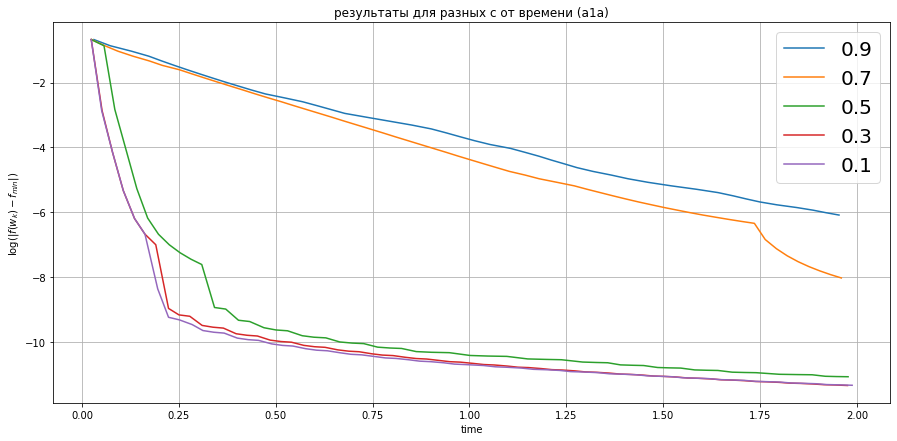

In [112]:
vs = np.array([v1-f_min_a1a, v2-f_min_a1a, v3-f_min_a1a, v4-f_min_a1a, v5-f_min_a1a])
graph_several([t1, t2, t3, t4, t5], vs,
              labels=['0.9', '0.7', '0.5', '0.3', '0.1'],
              x_l='time', y_l='$\log(|f(w_k)-f_{min}|)$', title='результаты для разных c от времени (a1a)')

In [113]:
a1, i1, t1, v1, r1, fc1, gc1, hc1 = optimization_task(oracle, w0_cancer, method='newton', args=[X_cancer, labels_cancer, outers_cancer],
                                          one_dim_search='armiho', max_time=2, search_kwargs=dict([('c', 0.9)]))
a2, i2, t2, v2, r2, fc2, gc2, hc2 = optimization_task(oracle, w0_cancer, method='newton', args=[X_cancer, labels_cancer, outers_cancer],
                                          one_dim_search='armiho', max_time=2, search_kwargs=dict([('c', 0.7)]))
a3, i3, t3, v3, r3, fc3, gc3, hc3 = optimization_task(oracle, w0_cancer, method='newton', args=[X_cancer, labels_cancer, outers_cancer],
                                          one_dim_search='armiho', max_time=2, search_kwargs=dict([('c', 0.5)]))
a4, i4, t4, v4, r4, fc4, gc4, hc4 = optimization_task(oracle, w0_cancer, method='newton', args=[X_cancer, labels_cancer, outers_cancer],
                                          one_dim_search='armiho', max_time=2, search_kwargs=dict([('c', 0.3)]))
a5, i5, t5, v5, r5, fc5, gc5, hc5 = optimization_task(oracle, w0_cancer, method='newton', args=[X_cancer, labels_cancer, outers_cancer],
                                           one_dim_search='armiho', max_time=2, search_kwargs=dict([('c', 0.1)]))

C:\Users\Nikita\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


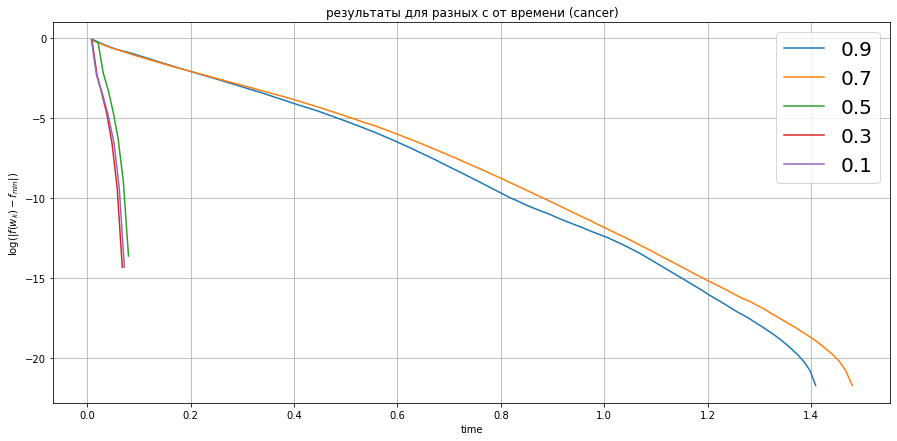

In [114]:
vs = np.array([v1-f_min_cancer, v2-f_min_cancer, v3-f_min_cancer, v4-f_min_cancer, v5-f_min_cancer])
graph_several([t1, t2, t3, t4, t5], vs,
              labels=['0.9', '0.7', '0.5', '0.3', '0.1'],
              x_l='time', y_l='$\log(|f(w_k)-f_{min}|)$', title='результаты для разных c от времени (cancer)')

Для $c$, близких к 1, за одну итерацию функция не может сильно уменьшиться. Впредь будем использовать $c$ = 0.1 - при меньших значениях ситауция не особо меняется.

### Wolf: зависимость от $с_2$:

Зависимость от $c_1$ (коэфицента для условия Армихо) похожа на аналогичную в методе Армихо, так что здесь не представлена

In [139]:

a1, i1, t1, v1, r1, fc1, gc1, hc1 = optimization_task(oracle, w0_cancer, method='newton', args=[X_cancer, labels_cancer, outers_cancer],
                                          one_dim_search='wolf', max_time=0.1, search_kwargs=dict([('c2', 0.9)]))
a2, i2, t2, v2, r2, fc2, gc2, hc2 = optimization_task(oracle, w0_cancer, method='newton', args=[X_cancer, labels_cancer, outers_cancer],
                                          one_dim_search='wolf', max_time=0.1, search_kwargs=dict([('c2', 0.2)]))
a3, i3, t3, v3, r3, fc3, gc3, hc3 = optimization_task(oracle, w0_cancer, method='newton', args=[X_cancer, labels_cancer, outers_cancer],
                                          one_dim_search='wolf', max_time=0.1, search_kwargs=dict([('c2', 0.15)]))
a4, i4, t4, v4, r4, fc4, gc4, hc4 = optimization_task(oracle, w0_cancer, method='newton', args=[X_cancer, labels_cancer, outers_cancer],
                                          one_dim_search='wolf', max_time=0.1, search_kwargs=dict([('c2', 0.1)]))
a5, i5, t5, v5, r5, fc5, gc5, hc5 = optimization_task(oracle, w0_cancer, method='newton', args=[X_cancer, labels_cancer, outers_cancer],
                                           one_dim_search='wolf', max_time=0.1, search_kwargs=dict([('c2', 0.001)]))

C:\Users\Nikita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Nikita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Nikita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


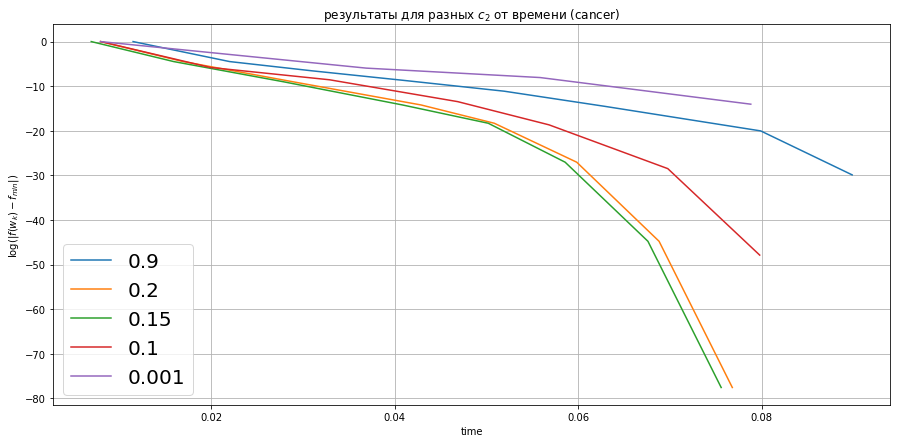

In [140]:
vs = np.array([v1-f_min_cancer, v2-f_min_cancer, v3-f_min_cancer, v4-f_min_cancer, v5-f_min_cancer])
graph_several([t1, t2, t3, t4, t5], [r1, r2, r3, r4, r5],
              labels=['0.9', '0.2', '0.15', '0.1', '0.001'],
              x_l='time', y_l='$\log(|f(w_k)-f_{min}|)$', title='результаты для разных $c_2$ от времени (cancer)')

In [ ]:
vs = np.array([v1-f_min_cancer, v2-f_min_cancer, v3-f_min_cancer, v4-f_min_cancer, v5-f_min_cancer])
graph_several([i1, i2, i3, i4, i5], [r1, r2, r3, r4, r5],
              labels=['0.9', '0.2', '0.15', '0.1', '0.001'], beg = 100,
              x_l='iteration', y_l='$\log(|f(w_k)-f_{min}|)$', title='результаты для разных $c_2$ от номера итерации (cancer)')

In [68]:
a1, i1, t1, v1, r1, fc1, gc1, hc1 = optimization_task(oracle, w0_a1a, method='gradient descent', args=[X_a1a, labels_a1a],
                                          one_dim_search='wolf', max_time=10, search_kwargs=dict([('c2', 0.9)]))
a2, i2, t2, v2, r2, fc2, gc2, hc2 = optimization_task(oracle, w0_a1a, method='gradient descent', args=[X_a1a, labels_a1a],
                                          one_dim_search='wolf', max_time=10, search_kwargs=dict([('c2', 0.2)]))
a3, i3, t3, v3, r3, fc3, gc3, hc3 = optimization_task(oracle, w0_a1a, method='gradient descent', args=[X_a1a, labels_a1a],
                                          one_dim_search='wolf', max_time=10, search_kwargs=dict([('c2', 0.15)]))
a4, i4, t4, v4, r4, fc4, gc4, hc4 = optimization_task(oracle, w0_a1a, method='gradient descent', args=[X_a1a, labels_a1a],
                                          one_dim_search='wolf', max_time=10, search_kwargs=dict([('c2', 0.1)]))
a5, i5, t5, v5, r5, fc5, gc5, hc5 = optimization_task(oracle, w0_a1a, method='gradient descent', args=[X_a1a, labels_a1a],
                                           one_dim_search='wolf', max_time=10, search_kwargs=dict([('c2', 0.001)]))

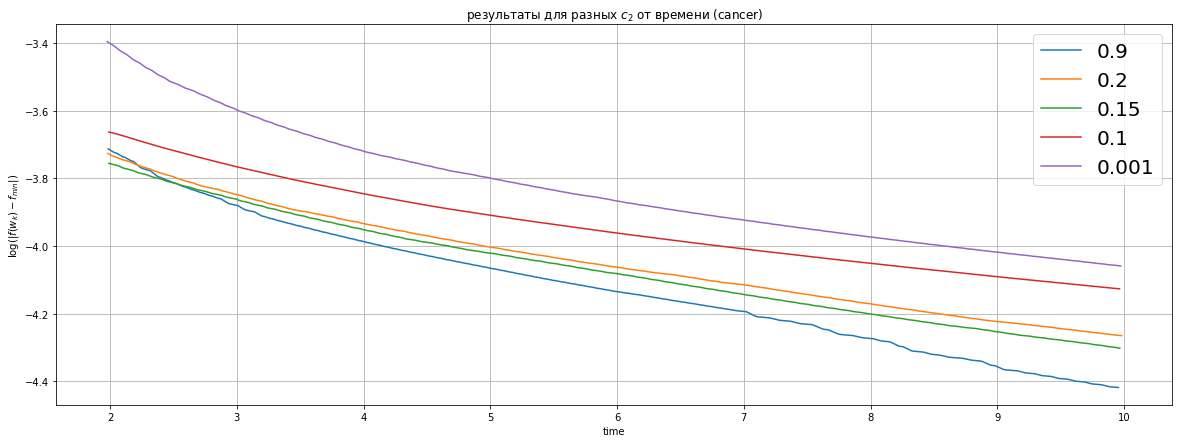

In [78]:
vs = np.array([v1-f_min_a1a, v2-f_min_a1a, v3-f_min_a1a, v4-f_min_a1a, v5-f_min_a1a])
graph_several([t1, t2, t3, t4, t5], vs,
              labels=['0.9', '0.2', '0.15', '0.1', '0.001'], beg=2,
              x_l='time', y_l='$\log(|f(w_k)-f_{min}|)$', title='результаты для разных $c_2$ от времени (a1a)')

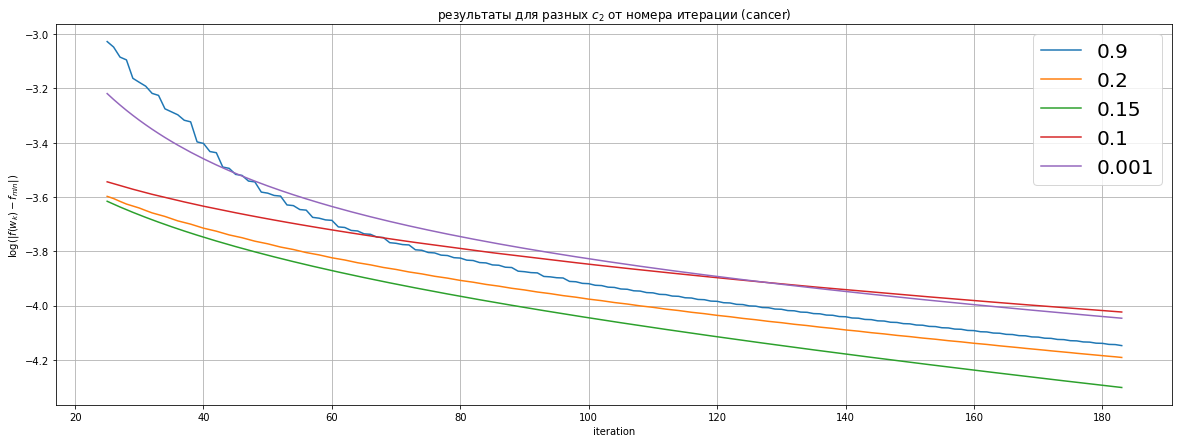

In [80]:
vs = np.array([v1-f_min_a1a, v2-f_min_a1a, v3-f_min_a1a, v4-f_min_a1a, v5-f_min_a1a])
graph_several([i1, i2, i3, i4, i5], vs,
              labels=['0.9', '0.2', '0.15', '0.1', '0.001'], beg=25,
              x_l='iteration', y_l='$\log(|f(w_k)-f_{min}|)$', title='результаты для разных $c_2$ от номера итерации (a1a)')

Не очень понятная зависимость, но для данных датасетов оптимальной является $c_2\approx 0.1$

In [86]:
a1, i1, t1, v1, r1, fc1, gc1, hc1 = optimization_task(oracle, w0_rand, method='gradient descent', args=[X_rand, labels_rand],
                                          one_dim_search='wolf', max_time=10, search_kwargs=dict([('c2', 0.9)]))
a2, i2, t2, v2, r2, fc2, gc2, hc2 = optimization_task(oracle, w0_rand, method='gradient descent', args=[X_rand, labels_rand],
                                          one_dim_search='wolf', max_time=10, search_kwargs=dict([('c2', 0.2)]))
a3, i3, t3, v3, r3, fc3, gc3, hc3 = optimization_task(oracle, w0_rand, method='gradient descent', args=[X_rand, labels_rand],
                                          one_dim_search='wolf', max_time=10, search_kwargs=dict([('c2', 0.15)]))
a4, i4, t4, v4, r4, fc4, gc4, hc4 = optimization_task(oracle, w0_rand, method='gradient descent', args=[X_rand, labels_rand],
                                          one_dim_search='wolf', max_time=10, search_kwargs=dict([('c2', 0.1)]))
a5, i5, t5, v5, r5, fc5, gc5, hc5 = optimization_task(oracle, w0_rand, method='gradient descent', args=[X_rand, labels_rand],
                                           one_dim_search='wolf', max_time=10, search_kwargs=dict([('c2', 0.001)]))

C:\Users\Nikita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Nikita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Nikita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Nikita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Nikita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The 

## Метод Ньютона: сравнение разных стратегий


#### $\log(\frac{|\nabla f(w_k)|^2}{|\nabla f(w_0)|^2})$ для cancer:

In [197]:
a1, i1, t1, v1, r1, fc1, gc1, hc1 = optimization_task(oracle, w0_cancer, method='newton', args=[X_cancer, labels_cancer, outers_cancer],
                                          one_dim_search='brent', max_time=2)
a2, i2, t2, v2, r2, fc2, gc2, hc2 = optimization_task(oracle, w0_cancer, method='newton', args=[X_cancer, labels_cancer, outers_cancer],
                                          one_dim_search='golden', max_time=2, search_kwargs=dict([('eps', 0.00001)]))
a3, i3, t3, v3, r3, fc3, gc3, hc3 = optimization_task(oracle, w0_cancer, method='newton', args=[X_cancer, labels_cancer, outers_cancer],
                                          one_dim_search='armiho', max_time=2)
a4, i4, t4, v4, r4, fc4, gc4, hc4 = optimization_task(oracle, w0_cancer, method='newton', args=[X_cancer, labels_cancer, outers_cancer],
                                          one_dim_search='wolf', max_time=2)
a5, i5, t5, v5, r5, fc5, gc5, hc5 = optimization_task(oracle, w0_cancer, method='newton', args=[X_cancer, labels_cancer, outers_cancer],
                                           one_dim_search='unit step', max_time=2)

C:\Users\Nikita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Nikita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Nikita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Nikita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Nikita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The 

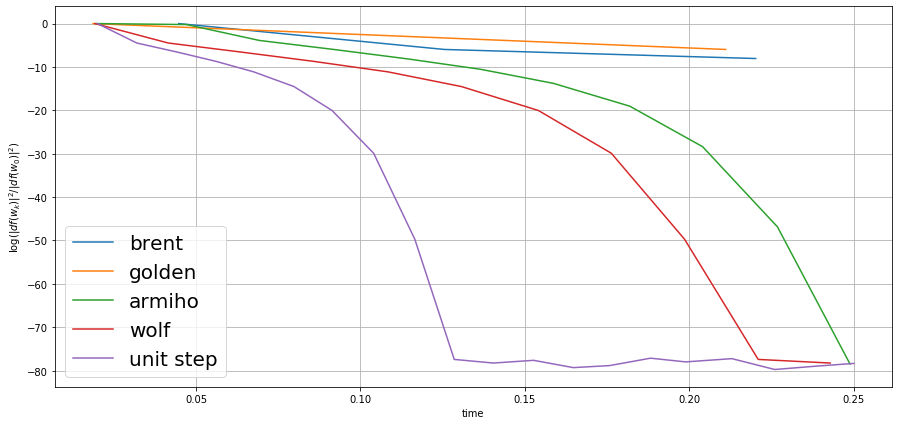

In [201]:
graph_several([t1, t2, t3, t4, t5], [r1, r2, r3, r4, r5],
              labels=['brent', 'golden', 'armiho', 'wolf', 'unit step'], end=0.25,
              x_l='time', y_l='$\log(|d f(w_k)|^2/|d f(w_0)|^2)$')

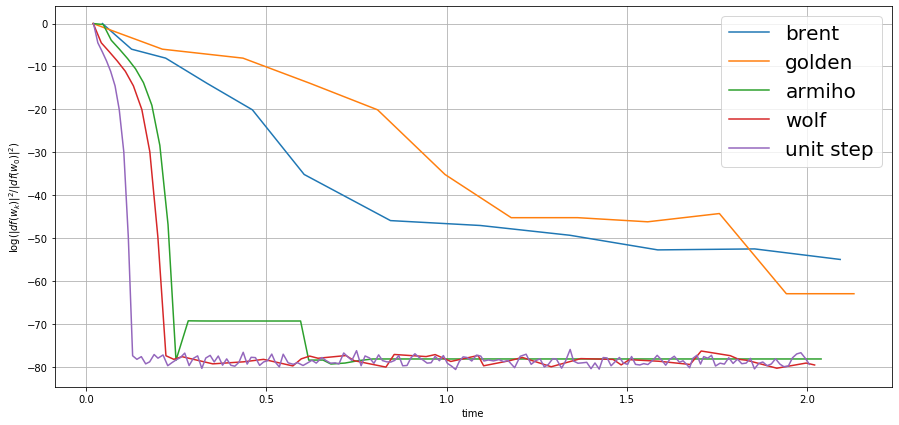

In [198]:
graph_several([t1, t2, t3, t4, t5], [r1, r2, r3, r4, r5],
              labels=['brent', 'golden', 'armiho', 'wolf', 'unit step'], end=2,
              x_l='time', y_l='$\log(|d f(w_k)|^2/|d f(w_0)|^2)$')

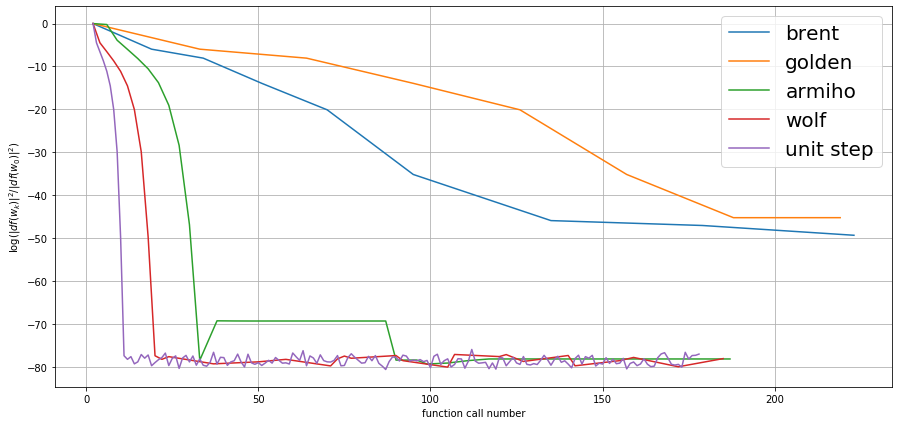

In [189]:
graph_several([fc1, fc2, fc3, fc4, fc5], [r1, r2, r3, r4, r5],
              labels=['brent', 'golden', 'armiho', 'wolf', 'unit step'],
              x_l='function call number', y_l='$\log(| df(w_k)|^2/| df(w_0)|^2)$')

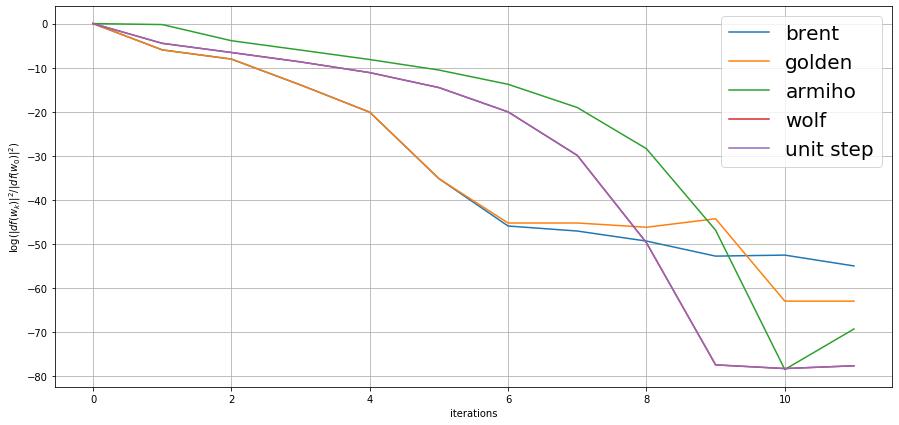

In [192]:
graph_several([i1, i2, i3, i4, i5], [r1, r2, r3, r4, r5],
              labels=['brent', 'golden', 'armiho', 'wolf', 'unit step'], end = 10,
              x_l='iterations', y_l='$\log(| df(w_k)|^2/| df(w_0)|^2)$')

#### $\log(|f(w_k)-f_{min}|)$ для a1a:

In [247]:
a1, i1, t1, v1, r1, fc1, gc1, hc1 = optimization_task(oracle, w0_a1a, method='newton', args=[X_a1a, labels_a1a, outers_a1a],
                                          one_dim_search='brent', max_time=2)
a2, i2, t2, v2, r2, fc2, gc2, hc2 = optimization_task(oracle, w0_a1a, method='newton', args=[X_a1a, labels_a1a, outers_a1a],
                                          one_dim_search='golden', max_time=2, search_kwargs=dict([('eps', 0.00001)]))
a3, i3, t3, v3, r3, fc3, gc3, hc3 = optimization_task(oracle, w0_a1a, method='newton', args=[X_a1a, labels_a1a, outers_a1a],
                                          one_dim_search='armiho', max_time=2)
a4, i4, t4, v4, r4, fc4, gc4, hc4 = optimization_task(oracle, w0_a1a, method='newton', args=[X_a1a, labels_a1a, outers_a1a],
                                          one_dim_search='wolf', max_time=2)
a5, i5, t5, v5, r5, fc5, gc5, hc5 = optimization_task(oracle, w0_a1a, method='newton', args=[X_a1a, labels_a1a, outers_a1a],
                                           one_dim_search='unit step', max_time=2)

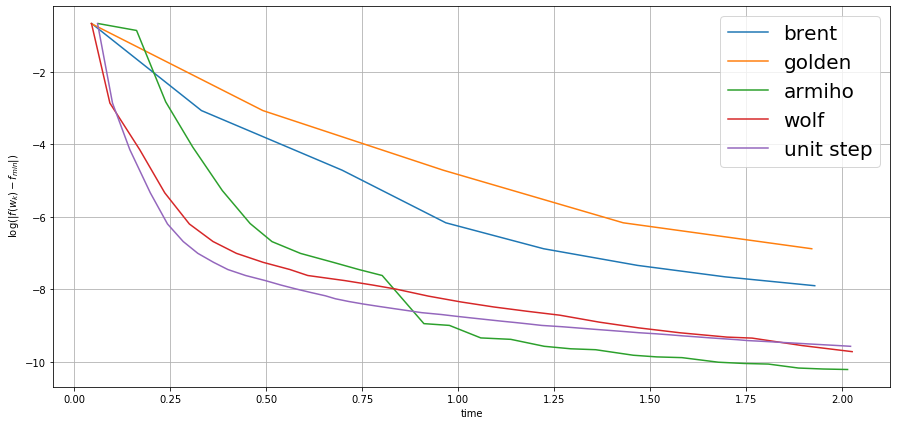

In [248]:
vs = np.array([v1- f_min_a1a, v2- f_min_a1a, v3- f_min_a1a, v4- f_min_a1a, v5- f_min_a1a]) 
graph_several([t1, t2, t3, t4, t5], vs,
              labels=['brent', 'golden', 'armiho', 'wolf', 'unit step'],
              x_l='time', y_l=' $\log(|f(w_k)-f_{min}|)$')

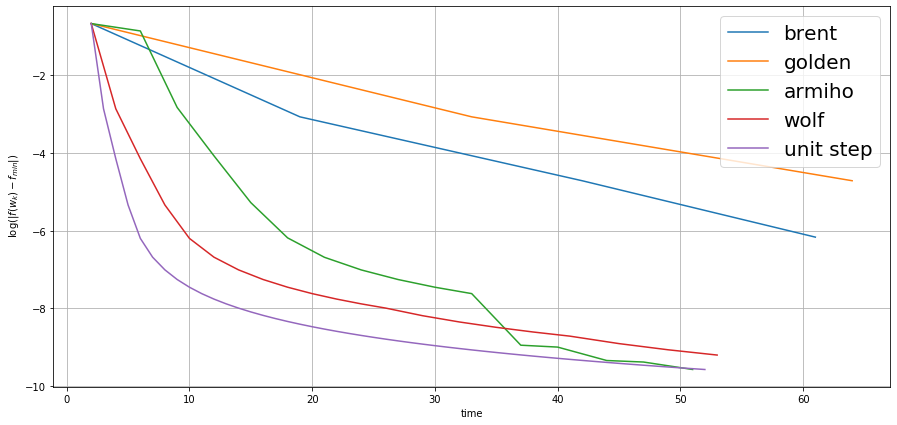

In [249]:
graph_several([fc1, fc2, fc3, fc4, fc5], vs,
              labels=['brent', 'golden', 'armiho', 'wolf', 'unit step'],
              x_l='time', y_l=' $\log(|f(w_k)-f_{min}|)$')

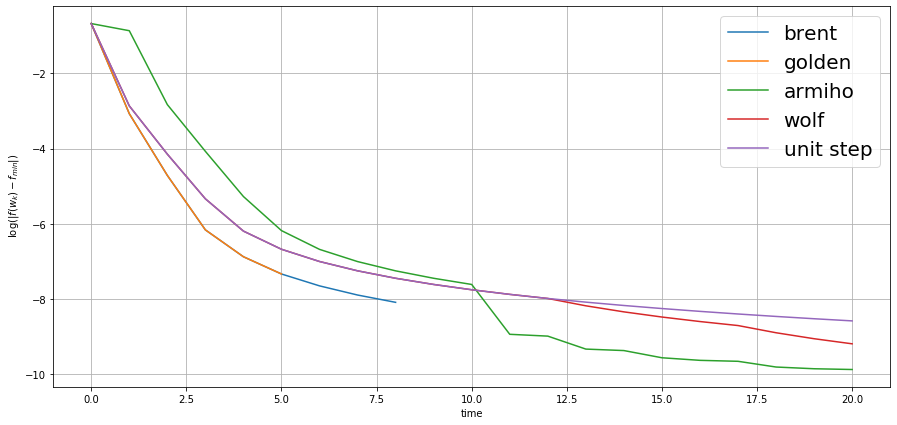

In [253]:
graph_several([i1, i2, i3, i4, i5], vs,
              labels=['brent', 'golden', 'armiho', 'wolf', 'unit step'], end=20,
              x_l='time', y_l=' $\log(|f(w_k)-f_{min}|)$')

#### $\log(\frac{|\nabla f(w_k)|^2}{|\nabla f(w_0)|^2})$ для сгенерированного датасета:

In [255]:
a1, i1, t1, v1, r1, fc1, gc1, hc1 = optimization_task(oracle, w0_rand, method='newton', args=[X_rand, labels_rand, outers_rand],
                                           one_dim_search='brent', max_time=2)
a2, i2, t2, v2, r2, fc2, gc2, hc2 = optimization_task(oracle, w0_rand, method='newton', args=[X_rand, labels_rand, outers_rand],
                                           one_dim_search='golden', max_time=2, search_kwargs=dict([('eps', 0.00001)]))
a3, i3, t3, v3, r3, fc3, gc3, hc3 = optimization_task(oracle, w0_rand, method='newton', args=[X_rand, labels_rand, outers_rand],
                                           one_dim_search='armiho', max_time=2)
a4, i4, t4, v4, r4, fc4, gc4, hc4 = optimization_task(oracle, w0_rand, method='newton', args=[X_rand, labels_rand, outers_rand],
                                           one_dim_search='wolf', max_time=2)
a5, i5, t5, v5, r5, fc5, gc5, hc5 = optimization_task(oracle, w0_rand, method='newton', args=[X_rand, labels_rand, outers_rand],
                                           one_dim_search='unit step', max_time=2)

C:\Users\Nikita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Nikita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Nikita\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


C:\Users\Nikita\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


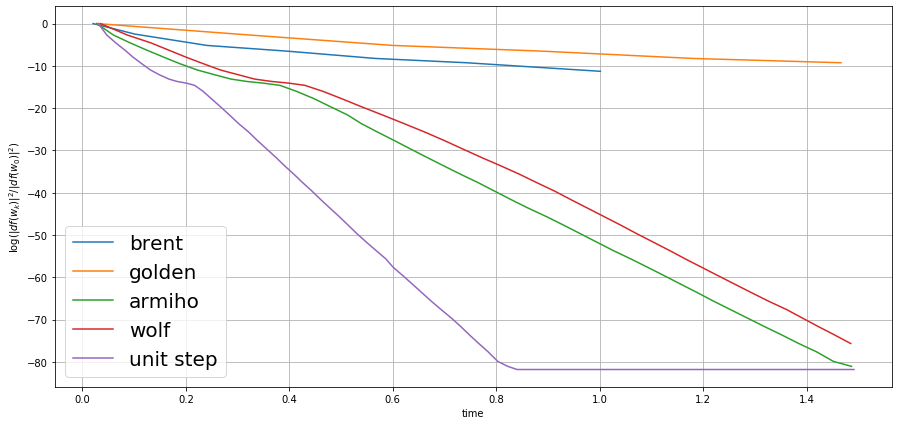

In [258]:
graph_several([t1, t2, t3, t4, t5], [r1, r2, r3, r4, r5],
              labels=['brent', 'golden', 'armiho', 'wolf', 'unit step'],
              x_l='time', y_l='$\log(|d f(w_k)|^2/|d f(w_0)|^2)$')

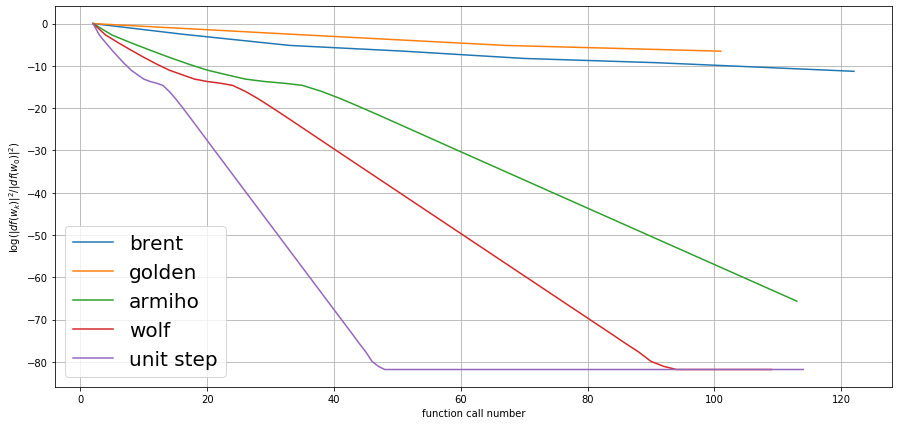

In [259]:
graph_several([fc1, fc2, fc3, fc4, fc5], [r1, r2, r3, r4, r5],
              labels=['brent', 'golden', 'armiho', 'wolf', 'unit step'],
              x_l='function call number', y_l='$\log(| df(w_k)|^2/| df(w_0)|^2)$')

C:\Users\Nikita\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


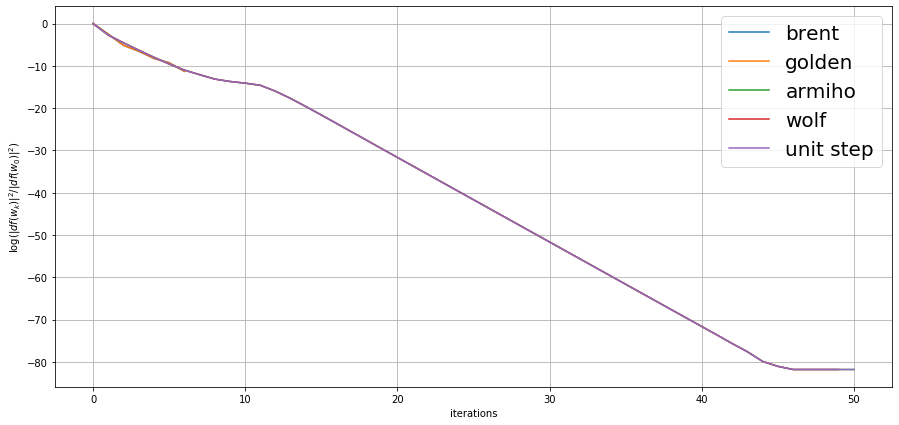

In [266]:
graph_several([i1, i2, i3, i4, i5], [r1, r2, r3, r4, r5],
              labels=['brent', 'golden', 'armiho', 'wolf', 'unit step'], end=50,
              x_l='iterations', y_l='$\log(|d f(w_k)|^2/|d f(w_0)|^2)$')